In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import dates
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse.linalg import spsolve as sp
from scipy import *
from scipy import sparse
from numpy import linalg

**Load dataset into dataframe**

In [2]:
df = pd.read_csv('Irrigation_without_000/feeds.csv', low_memory=False)
print(df.shape)
df = df.iloc[:, :12]
df.head()

(23690, 12)


created_at  entry_id  field1 (Ambient Temperature)  \
0  2021-08-01T11:14:03+00:00      1730                      31.92721   
1  2021-08-01T11:45:47+00:00      1731                      30.95120   
2  2021-08-01T11:49:13+00:00      1732                      31.92721   
3  2021-08-01T12:24:39+00:00      1733                      30.83540   
4  2021-08-01T13:03:40+00:00      1734                      31.43093   

   field2 (Ambient Humidity)  field3 (soil temperature)  \
0                   70.39309                   19.61952   
1                   71.45073                   19.80149   
2                   68.08391                   19.70223   
3                   72.01481                   19.76840   
4                   69.22969                   19.66915   

   field4 (Leaf wetness sensor)  field5 (Soil moisute sensor)  \
0                       13007.0                    10029.9820   
1                       13049.0                     9687.3379   
2                       13058.0                     9663.9463   
3                       13144.0                     9524.3271   
4                       13165.0                     9753.2695   

   field6 (Battery voltage)  latitude  longitude  elevation  status  
0                   3.83548       NaN        NaN        NaN     NaN  
1                   3.83097       NaN        NaN        NaN     NaN  
2                   3.83677       NaN        NaN        NaN     NaN  
3                   3.83871       NaN        NaN        NaN     NaN  
4                   3.82452       NaN        NaN        NaN     NaN

**Checking NULL Values**

In [3]:
df.isnull().sum(axis=0)

created_at                          0
entry_id                            0
field1 (Ambient Temperature)        0
field2 (Ambient Humidity)           0
field3 (soil temperature)           0
field4 (Leaf wetness sensor)        0
field5 (Soil moisute sensor)        0
field6 (Battery voltage)            0
latitude                        23690
longitude                       23690
elevation                       23690
status                          23690
dtype: int64

**Checking infinite Values**

In [4]:
# Describe The "field5 (Soil moisute sensor)" Feature
df['field5 (Soil moisute sensor)'].value_counts()

13888.8890    80
13908.4510    80
13550.5370    77
13532.0260    77
13513.5140    76
              ..
11715.1150     1
11748.8640     1
11574.7600     1
11548.0280     1
6464.5679      1
Name: field5 (Soil moisute sensor), Length: 10640, dtype: int64

**Handling Infinite Values**

In [5]:
# Handling Infinite Values as NULL Values Using 0 (Discussed)
df['field5 (Soil moisute sensor)'] = df['field5 (Soil moisute sensor)'].replace(np.inf,0)

**Drop The Unnecessary Columns/Features**

In [6]:
#df.drop(['entry_id', 'field6 (Battery voltage)', 'latitude', 'longitude', 'elevation', 'status'], axis=1, inplace=True)
df.head()

created_at  entry_id  field1 (Ambient Temperature)  \
0  2021-08-01T11:14:03+00:00      1730                      31.92721   
1  2021-08-01T11:45:47+00:00      1731                      30.95120   
2  2021-08-01T11:49:13+00:00      1732                      31.92721   
3  2021-08-01T12:24:39+00:00      1733                      30.83540   
4  2021-08-01T13:03:40+00:00      1734                      31.43093   

   field2 (Ambient Humidity)  field3 (soil temperature)  \
0                   70.39309                   19.61952   
1                   71.45073                   19.80149   
2                   68.08391                   19.70223   
3                   72.01481                   19.76840   
4                   69.22969                   19.66915   

   field4 (Leaf wetness sensor)  field5 (Soil moisute sensor)  \
0                       13007.0                    10029.9820   
1                       13049.0                     9687.3379   
2                       13058.0                     9663.9463   
3                       13144.0                     9524.3271   
4                       13165.0                     9753.2695   

   field6 (Battery voltage)  latitude  longitude  elevation  status  
0                   3.83548       NaN        NaN        NaN     NaN  
1                   3.83097       NaN        NaN        NaN     NaN  
2                   3.83677       NaN        NaN        NaN     NaN  
3                   3.83871       NaN        NaN        NaN     NaN  
4                   3.82452       NaN        NaN        NaN     NaN

**SubPlot of Dataset**

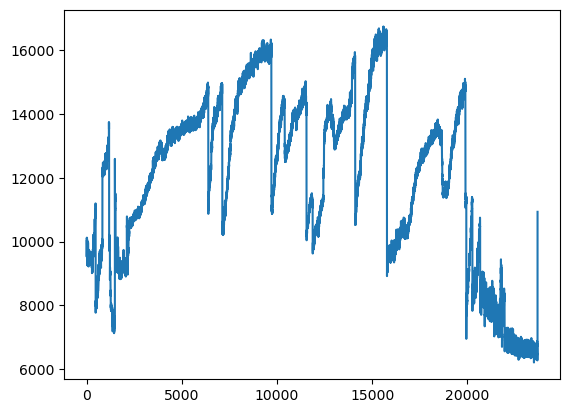

In [7]:
#df.plot(subplots=True, figsize=(30,60))
plt.plot(df['field5 (Soil moisute sensor)'])
plt.show()

#**Leaf Wetness Sensor**

In [8]:
# Import Library
from sklearn.preprocessing import MinMaxScaler

# Create Object of MinMaxScaler
min_max_scaler = MinMaxScaler()

# Normalized The LWS Data
lws_scaled = min_max_scaler.fit_transform(df[['field4 (Leaf wetness sensor)']])
lws_scaled = pd.DataFrame(lws_scaled)

**Flip LWS Data**

In [9]:
# Implement Manually MinMaxScaler
att1 = -lws_scaled.iloc[:,0]
z1=[]
for i in range(len(att1)):
    z1.append((att1[i]-att1.min())/(att1.max()-att1.min()))

# Scaled Data Store In DataFrame
lws_scaled['LWS_Scaled'] = z1

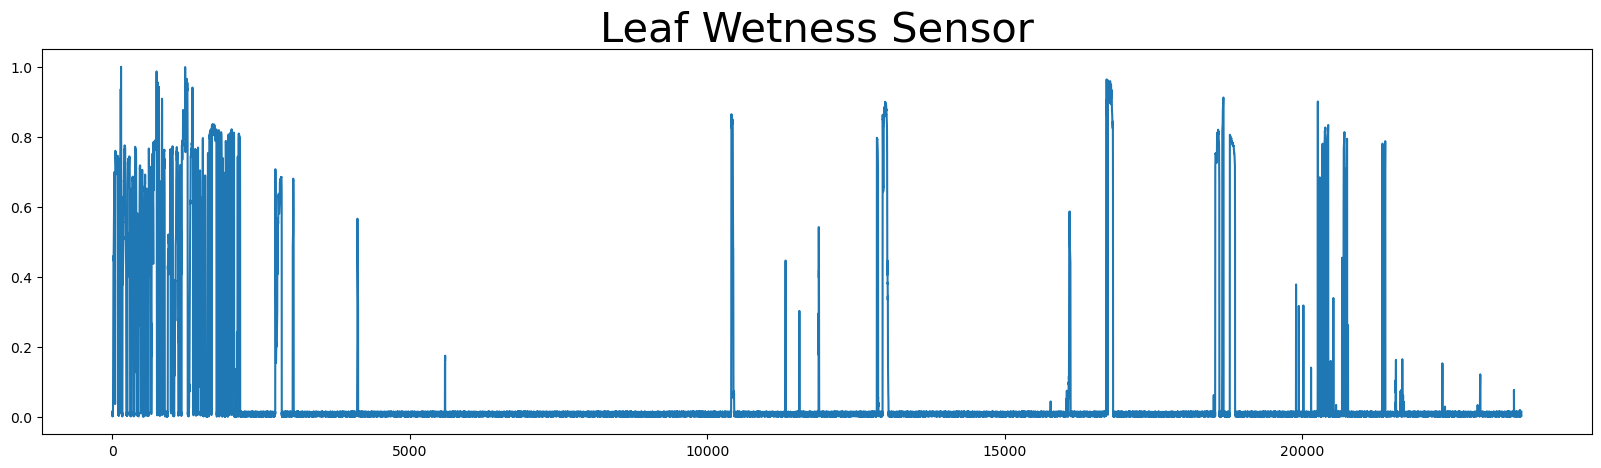

In [10]:
plt.figure(figsize=(20,5))
ax = plt.axes()
  
# Plot using set_facecolor() method
ax.set_facecolor("white")

plt.title("Leaf Wetness Sensor", fontsize=30)
#plt.ylim(1, 0)
#tmp=plt.gca().invert_yaxis()
plt.plot(lws_scaled['LWS_Scaled'])

**Denoising -** Leaf Wetness Sensor

In [11]:
# Define Function For Denoising The Noisy Signal/Data
def TVD_MM(y, lam, Nit):
  y = y
  cost = np.zeros((1, Nit))
  N = len(y)

  D = sparse.diags([-1, 1], [0, 1], shape = ((N-1), N))
  DT = D.transpose()
  DDT = D.dot(D.transpose())

  x = y
  Dx = D.dot(x)
  Dy = D.dot(y)

  for k in range(Nit):
    F = sparse.diags((abs(Dx)/lam), shape = ((N-1), (N-1))) + DDT
    x = y - (DT.dot(sp(F, Dy)))
    Dx = D.dot(x)
    cost[0, k] = 0.5 * (sum(np.square(abs(x-y)))) + lam * (sum(abs(Dx)))
  
  np.reshape(cost, (Nit, 1))
  return x

In [12]:
# TVD MM Function Calling
lws_denoised = TVD_MM(lws_scaled['LWS_Scaled'], 0.02, 100)


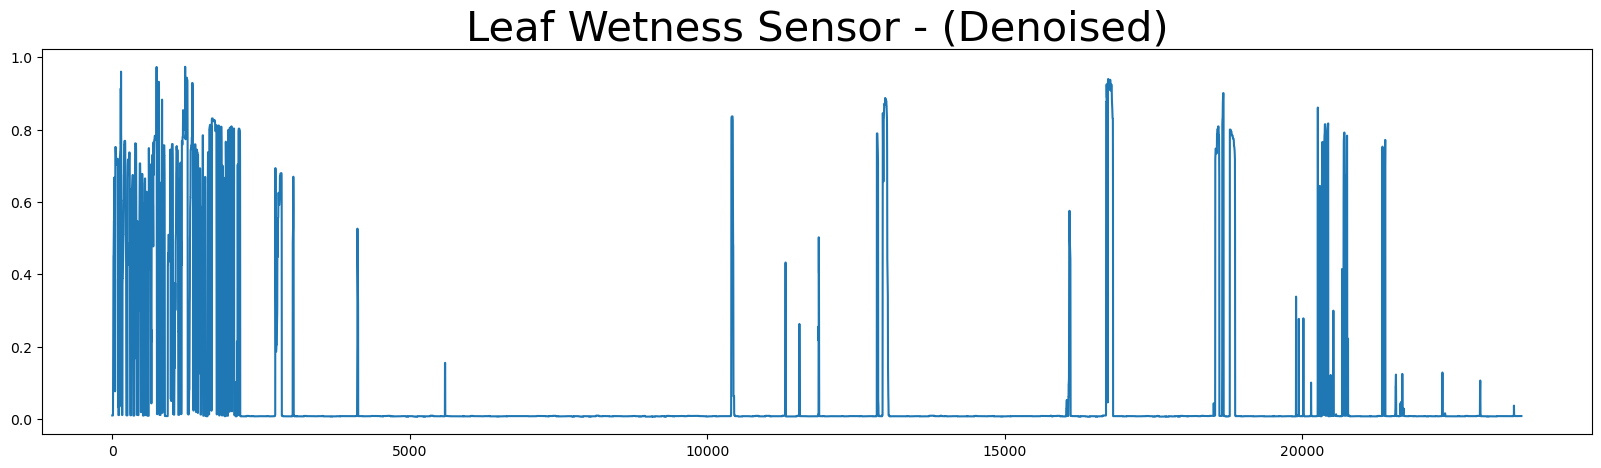

In [13]:
plt.figure(figsize=(20,5))
ax = plt.axes()
  
# Plot using set_facecolor() method
ax.set_facecolor("white")

plt.title("Leaf Wetness Sensor - (Denoised)", fontsize=30)
plt.plot(lws_denoised)
# plt.xticks(rotation=45) # X - Axis Label Rotation

**Baseline Correction -** Leaf Wetness Sensor

In [14]:
# Define Function For Baseline Correction
def baseline_als_optimized(y, lam, lam1, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D1 = sparse.diags([-1,1],[0,1], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    D1 = lam1 * D1.dot(D1.transpose())
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        W = W.dot(W.transpose())
        Z = W + D + D1
        z = sp(Z, (W+D1).dot(y))
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [15]:
# Baseline Corection Function Calling
lws_base = baseline_als_optimized(lws_denoised, 500, 0.001, 0.005)

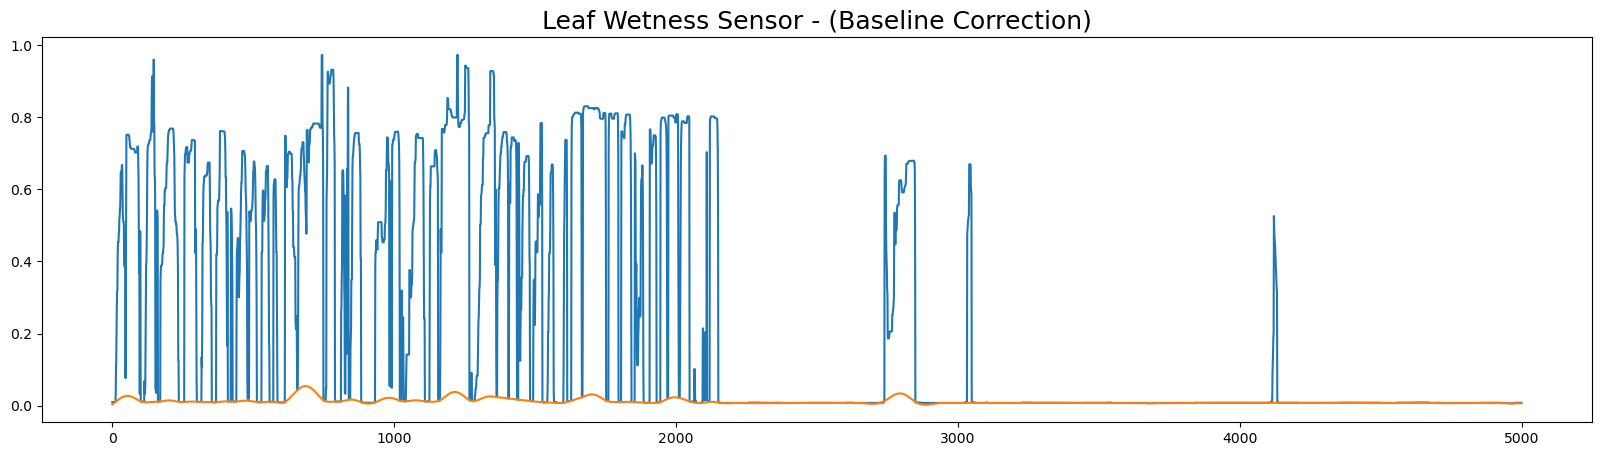

In [16]:
plt.figure(figsize=(20,5))
ax = plt.axes()
  
# Plot using set_facecolor() method
ax.set_facecolor("white")

lws_diff = lws_denoised - lws_base


plt.title("Leaf Wetness Sensor - (Baseline Correction)", fontsize=18)
plt.plot(lws_denoised[:5000])
plt.plot(lws_base[:5000])
# plt.xticks(rotation=45) # X - Axis Label Rotation

**Start Point & End Point**

In [17]:
# Finding Start & End Point Index, So We Can Get DataTime Using Index
start = []
end = []
for i in range(len(lws_diff)-1):
  if((lws_diff[i] < 0.05) and (lws_diff[i+1] > 0.05)):
    start.append(i)
  elif((lws_diff[i] > 0.05) and (lws_diff[i+1] < 0.05)):
    end.append(i) 

In [18]:
start_dt = df.created_at[start]
end_dt =  df.created_at[end]

In [19]:
# Start Time Convert Into List
lwd_start = [] 
for i in start:
  lwd_start.append(df.created_at[i])

# End Time Convert Into List
lwd_end = []
for i in end:
  lwd_end.append(df.created_at[i])

In [20]:
# Create DataFrame of Start & End Time
from datetime import datetime

lwd_duration = pd.DataFrame(list(zip(lwd_start, lwd_end)), columns =['Start', 'End'])

lwd_duration['Start'] = lwd_duration['Start'].astype('datetime64[ns]')
lwd_duration['End'] = lwd_duration['End'].astype('datetime64[ns]')
df['DateTime'] = df['created_at'].astype('datetime64[ns]')

lwd_duration['Duration'] = lwd_duration['End'] - lwd_duration['Start']

# Convert Duration Into Hours
for i in range(len(lwd_duration)):
    lwd_duration.loc[i, 'Duration'] = lwd_duration.loc[i, 'Duration'].total_seconds() / 3600



In [21]:
# creating dataframe for start and end points
start_index=df.loc[df['DateTime'].isin(lwd_duration['Start'])]
end_index = df.loc[df['DateTime'].isin(lwd_duration['End'])]

index = pd.DataFrame()
index['Start'] = start_index.index
index['End'] = end_index.index

# extracting list of start and end points
start_index = index['Start'].tolist()
end_index = index['End'].tolist()

In [22]:
# creating list for LWD for each record in df
lwd=[0] * len(df)

for start, end in zip(start_index, end_index):
  tmp = df['DateTime'][start:end+1]
  for k in range(start+1,end+1):
    cons = tmp[start]
    result = tmp[k] - cons
    lwd[k] = result

In [23]:
# Convert Duration Into Hours
for i in range (len(lwd)):
  if(lwd[i] != 0):
    lwd[i] = lwd[i].total_seconds()/3600

df['LWD']=lwd

In [24]:
# Create New DataFrame
data = pd.DataFrame(list(zip(df['DateTime'], df['field1 (Ambient Temperature)'], df['field2 (Ambient Humidity)'], df['field3 (soil temperature)'], df['LWD'], df['field5 (Soil moisute sensor)'])),
               columns =['DateTime', 'Ambient_Temperature', 'Ambient_Humidity', 'Soil_Temperature', 'Leaf_Wetness_Duration', 'Soil_Moisture_Sensor'])

#**Soil Moisture Sensor**

----

**Calibration data**

In [25]:
# Read CSV Data
df2  = pd.read_csv("Irrigation_without_000/calibration_data.csv")
print(df2)

   Gravimetric water content (GWC) (%)  Sensor Frequency (Hz)
0                                 3.12               11015.40
1                                 5.83                7642.87
2                                 7.40                6324.60
3                                 8.41                3224.64
4                                12.31                2377.73
5                                14.54                2123.49
6                                17.29                1071.15


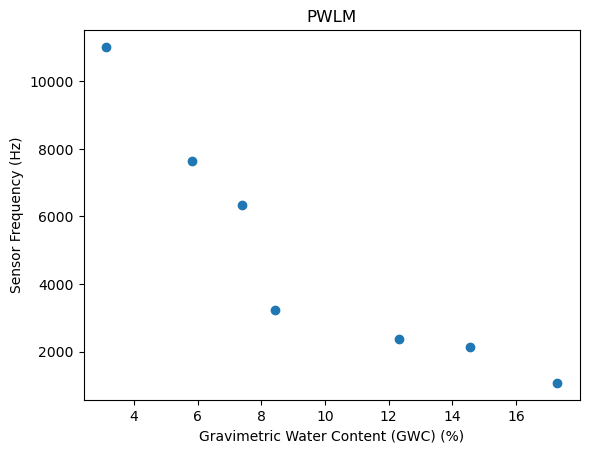

In [26]:
plt.scatter(df2['Gravimetric water content (GWC) (%)'], df2['Sensor Frequency (Hz)'], marker='o')
plt.xlabel('Gravimetric Water Content (GWC) (%)')
plt.ylabel('Sensor Frequency (Hz)')
plt.title('PWLM')
plt.show()

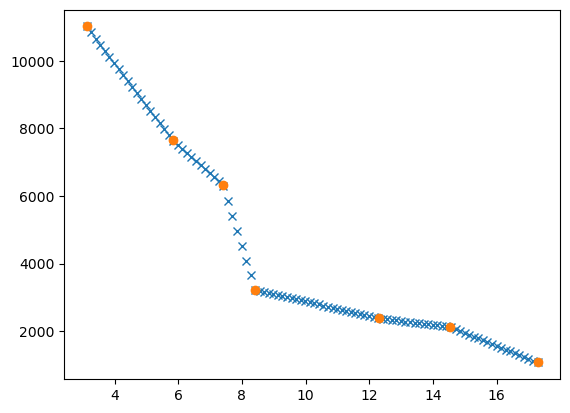

In [27]:
x = df2['Gravimetric water content (GWC) (%)']
X1 = np.linspace(x.min(), x.max(), 100)
x2 = x
y2 = df2['Sensor Frequency (Hz)']

Y1 = np.interp(X1, x2, y2)

# plt.figure(figsize=(12,7))
plt.plot(X1, Y1, 'x')
plt.plot(x2, y2, 'o')
plt.show()

In [28]:
(data['Soil_Moisture_Sensor'])

0        10029.9820
1         9687.3379
2         9663.9463
3         9524.3271
4         9753.2695
            ...    
23685     6453.4253
23686     6435.0708
23687     6464.5679
23688     6459.9917
23689    10933.7110
Name: Soil_Moisture_Sensor, Length: 23690, dtype: float64

**Piece-wise linear regression**

In [29]:
# Import Library
import pwlf

# fit your data (x and y)
myPWLF = pwlf.PiecewiseLinFit(Y1,X1)

# fit the data for n line segments
z = myPWLF.fit(6)

# calculate slopes
slopes = myPWLF.calc_slopes()

# predict for the determined points
xHat = Y1  
yHat = myPWLF.predict(data['Soil_Moisture_Sensor'])

# calculate statistics
p = myPWLF.p_values(method='non-linear', step_size=1e-4) #p-values
se = myPWLF.se  # standard errors

In [30]:
data['Soil_Moisture_Sensor'].value_counts()

13888.8890    80
13908.4510    80
13550.5370    77
13532.0260    77
13513.5140    76
              ..
11715.1150     1
11748.8640     1
11574.7600     1
11548.0280     1
6464.5679      1
Name: Soil_Moisture_Sensor, Length: 10640, dtype: int64

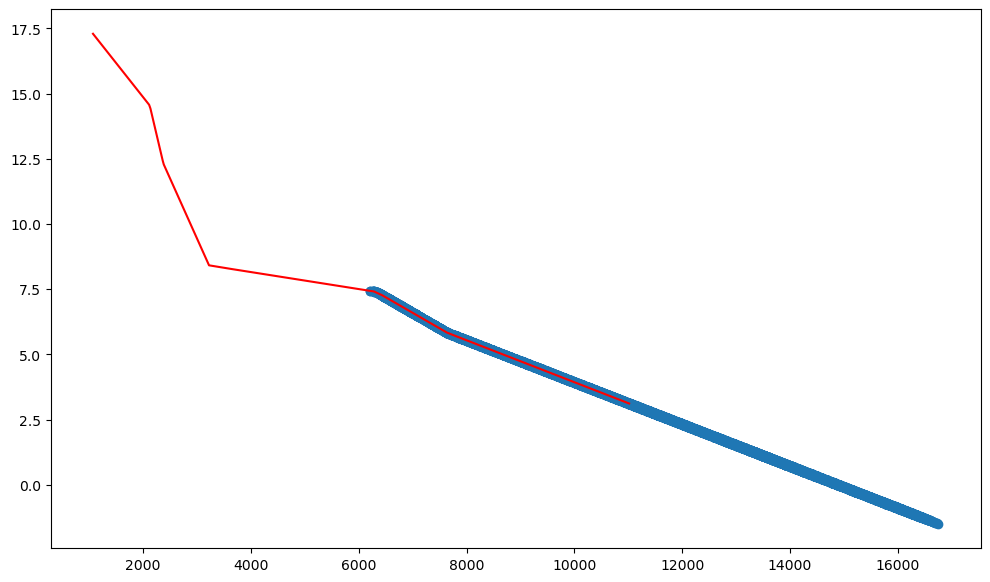

In [31]:
# Plot Prediction & Freq. Values
plt.figure(figsize=(12,7))
plt.scatter(data['Soil_Moisture_Sensor'], yHat)
plt.plot(Y1, X1, color="red")
plt.show()

In [32]:
# Update -VE predictions To 0
for i in range(len(yHat)):
  if (yHat[i]<0):
    yHat[i]=0

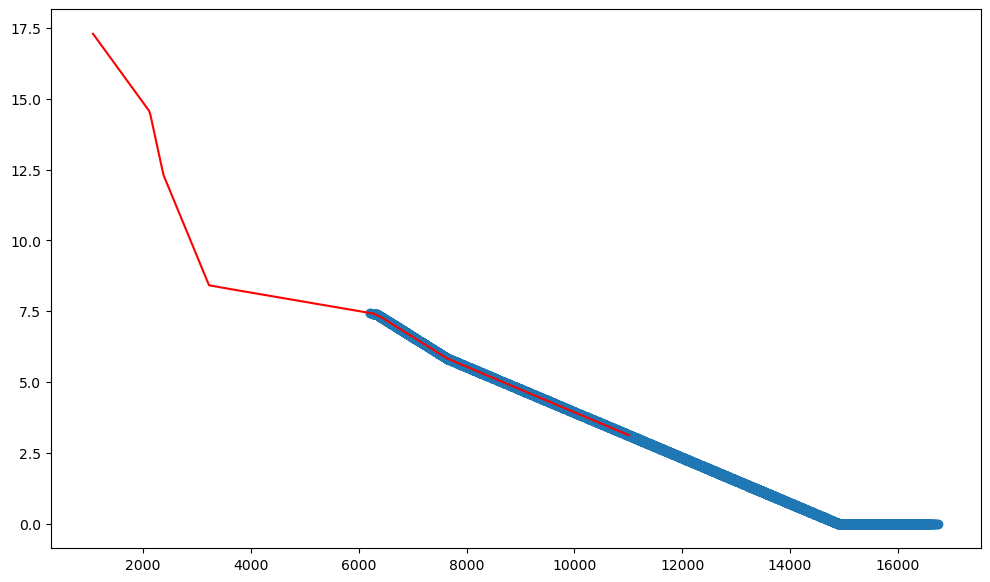

In [33]:
# Plot Prediction & Freq. Values
plt.figure(figsize=(12,7))
plt.scatter(data['Soil_Moisture_Sensor'], yHat)
plt.plot(Y1, X1, color="red")

**Add Soil Moisture Data Into DataFrame**

In [34]:
# Remove column name 'Soil_Moisture_Sensor'
data.drop(['Soil_Moisture_Sensor'], axis = 1, inplace = True)

# Add Soil Moisture
data['Soil_Moisture'] = yHat

In [35]:
arr = []

for i in range(len(data)):
  if(data['Soil_Moisture'][i] >= 12):
    arr.append(1)
  else:
    arr.append(0)

print(arr.count(0), arr.count(1))

23690 0


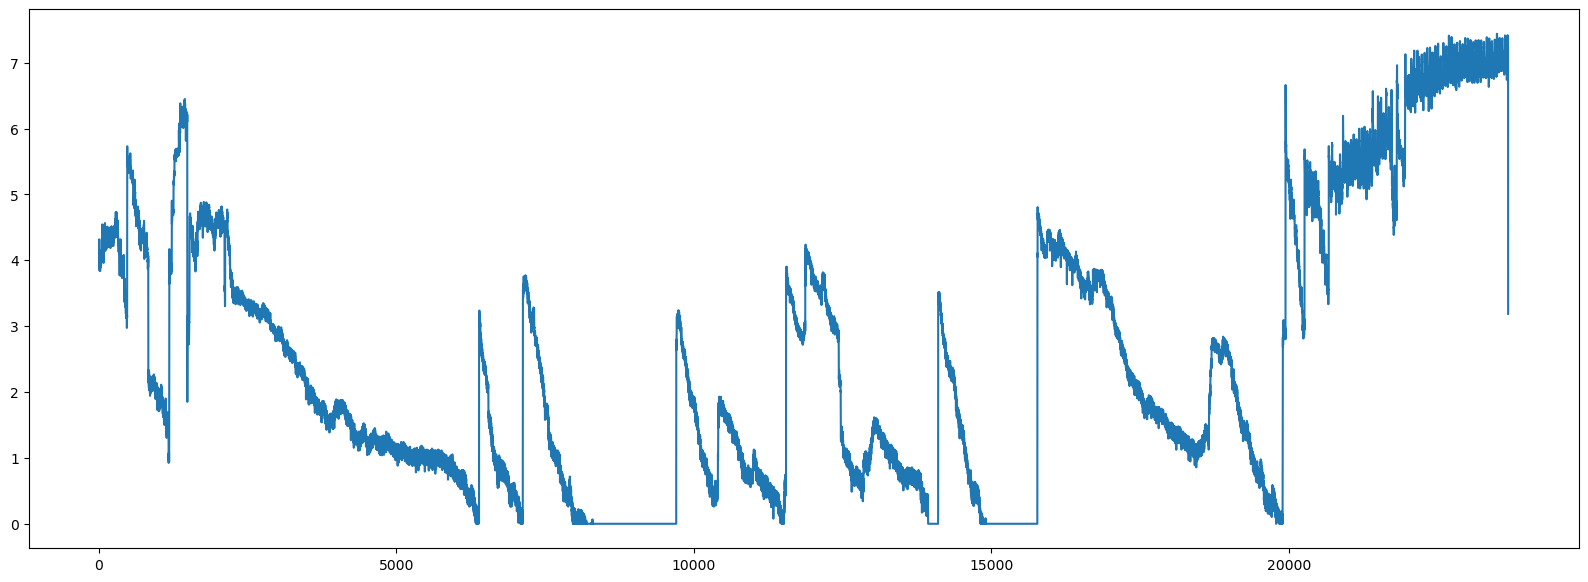

In [36]:
# Plot Prediction & Freq. Values
plt.figure(figsize=(20,7))
plt.plot(data['Soil_Moisture'])
plt.show()
data.to_csv('ana1.csv')

In [283]:
# p_summer = p_march+p_april+p_may
# p_monsoon = p_aug + p_sep + p_oct
# p_winter = p_nov + p_dec + p_jan + p_feb

In [284]:
# ana=data2.loc[(data2['Month'] == 11) | (data2['Month'] == 12) | (data2['Month'] == 1) | (data2['Month'] == 2)]
# ana

In [37]:
data.to_csv('ana.csv')

In [40]:
# ana_irri=ana[['Soil_Moisture','Powdery_Mildew','Anthracnose','Root_Rot','Month','Hours']]
# plt.figure(figsize = (12, 7))
# sns.heatmap(ana_irri.corr(), annot=True, cmap='Blues' )
# plt.show()

#**Powdery Mildew Features Based On Condition**

In [38]:
# Soil Moisture
d1_soil = []

for i in range(len(data)):
  if(data['Soil_Moisture'][i] >= 12):
    d1_soil.append(1)
  else:
    d1_soil.append(0)

In [39]:
# Leaf Wetness Duration
d1_lwd = []

for i in range(len(data)):
  if(data['Leaf_Wetness_Duration'][i] >= 96):
    d1_lwd.append(1)
  else:
    d1_lwd.append(0)

In [40]:
# AT & AH
d1_at_ah = []

for i in range(len(data)):
  if((data['Ambient_Temperature'][i] >= 10 and data['Ambient_Temperature'][i] <= 15) and (data['Ambient_Humidity'][i] >= 70 and data['Ambient_Humidity'][i] <= 80)):
    d1_at_ah.append(1)
  else:
    d1_at_ah.append(0)

In [41]:
# Soil Temp
d1_soil_tmp = []

for i in range(len(data)):
  if(data['Soil_Temperature'][i] >= 8 and data['Soil_Temperature'][i] <= 13):
    d1_soil_tmp.append(1)
  else:
    d1_soil_tmp.append(0)

In [42]:
print(len(d1_soil), len(d1_lwd), len(d1_at_ah), len(d1_soil_tmp))

23690 23690 23690 23690


In [43]:
powdery_mildew = pd.DataFrame(zip(d1_soil, d1_lwd, d1_at_ah, d1_soil_tmp), columns = ['Soil_Moisture', 'LWD', 'A_Temperature_Humidity', 'Soil_Temperature'])

#**Anthracnose Features Based On Condition**

In [44]:
d2_at_ah = []

for i in range(len(data)):
  if pd.isna(data['Ambient_Temperature'][i]) or pd.isna(data['Ambient_Humidity'][i]):
    d2_at_ah.append(0)
  elif (int(float(data['Ambient_Temperature'][i])) >= 24 and int(float(data['Ambient_Temperature'][i])) <= 32) and int(float(data['Ambient_Humidity'][i])) >= 85:
    d2_at_ah.append(1)
  else:
    d2_at_ah.append(0)


In [45]:
# Soil Temp
d2_soil_tmp = []

for i in range(len(data)):
  if(data['Soil_Temperature'][i] >= 20 and data['Soil_Temperature'][i] <= 28):
    d2_soil_tmp.append(1)
  else:
    d2_soil_tmp.append(0)

In [46]:
print(len(d2_at_ah), len(d2_soil_tmp))

23690 23690


In [47]:
anthracose = pd.DataFrame(zip(d1_soil, d1_lwd, d2_at_ah, d2_soil_tmp), columns = ['Soil_Moisture', 'LWD', 'A_Temperature_Humidity', 'Soil_Temperature'])

#**Root Rot Features Based On Condition**

In [48]:
# AT & AH
d3_at_ah = []

for i in range(len(data)):
  if(data['Ambient_Temperature'][i] <= 24  and data['Ambient_Humidity'][i] >= 90):
    d3_at_ah.append(1)
  else:
    d3_at_ah.append(0)

In [49]:
# Soil Temp
d3_soil_tmp = []

for i in range(len(data)):
  if(data['Soil_Temperature'][i] <= 20):
    d3_soil_tmp.append(1)
  else:
    d3_soil_tmp.append(0)

In [50]:
print(len(d3_at_ah), len(d3_soil_tmp))

23690 23690


In [51]:
root_rot = pd.DataFrame(zip(d1_soil, d3_at_ah, d3_soil_tmp), columns = ['Soil_Moisture', 'A_Temperature_Humidity', 'Soil_Temperature'])

In [52]:
print(powdery_mildew.head())
print(anthracose.head())
print(root_rot.head())

   Soil_Moisture  LWD  A_Temperature_Humidity  Soil_Temperature
0              0    0                       0                 0
1              0    0                       0                 0
2              0    0                       0                 0
3              0    0                       0                 0
4              0    0                       0                 0
   Soil_Moisture  LWD  A_Temperature_Humidity  Soil_Temperature
0              0    0                       0                 0
1              0    0                       0                 0
2              0    0                       0                 0
3              0    0                       0                 0
4              0    0                       0                 0
   Soil_Moisture  A_Temperature_Humidity  Soil_Temperature
0              0                       0                 1
1              0                       0                 1
2              0                       0               

#**A_Temprature_Humidity - Replace Value 1 To 2**

In [53]:
# Powdery_Mildew Replace 1 To 2
for i in range(len(powdery_mildew)):
  if (powdery_mildew['A_Temperature_Humidity'][i] == 1):
    powdery_mildew['A_Temperature_Humidity'][i] = 2

In [54]:
# Powdery_Mildew Replace 1 To 2
for i in range(len(anthracose)):
  if (anthracose['A_Temperature_Humidity'][i] == 1):
    anthracose['A_Temperature_Humidity'][i] = 2

In [55]:
# Powdery_Mildew Replace 1 To 2
for i in range(len(root_rot)):
  if (root_rot['A_Temperature_Humidity'][i] == 1):
    root_rot['A_Temperature_Humidity'][i] = 2

**Create New Column Which Is Sum of Each And Every Row**

In [56]:
powdery_mildew['Sum'] = powdery_mildew.sum(axis = 1)
anthracose['Sum'] = anthracose.sum(axis = 1)
root_rot['Sum'] = root_rot.sum(axis = 1)

**Create lists for disease(labels)**

In [57]:
# 1. Powdery Mildew
lst1 = []
for i in range(len(powdery_mildew)):
  if(powdery_mildew['Sum'][i] >= 2):
    lst1.append(1)
  else:
    lst1.append(0)

# 2. Anthracnose
lst2 = []
for i in range(len(anthracose)):
  if(anthracose['Sum'][i] >= 2):
    lst2.append(1)
  else:
    lst2.append(0)

# 3. Root Rot
lst3 = []
for i in range(len(root_rot)):
  if(root_rot['Sum'][i] >= 2):
    lst3.append(1)
  else:
    lst3.append(0)

In [58]:
# Create New Column for Powdery Mildew
data['Powdery_Mildew'] = lst1

# Create New Column for Anthracnose
data['Anthracnose'] = lst2

# Create New Column for Root_Rot
data['Root_Rot'] = lst3

In [59]:
print(data['Powdery_Mildew'].value_counts())
print(data['Anthracnose'].value_counts())
print(data['Root_Rot'].value_counts())

0    23393
1      297
Name: Powdery_Mildew, dtype: int64
0    21530
1     2160
Name: Anthracnose, dtype: int64
0    21161
1     2529
Name: Root_Rot, dtype: int64


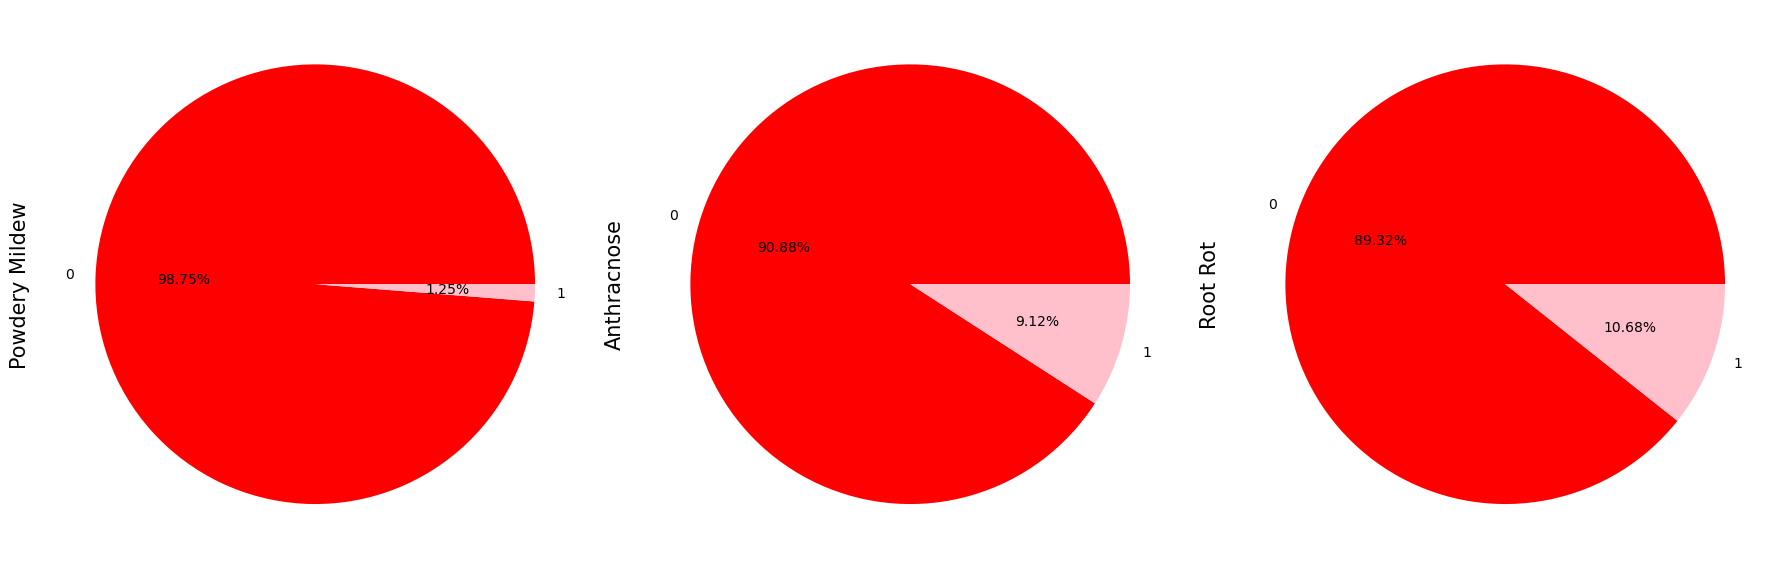

In [60]:
# Figure Size
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 9))

# Categorial data pie chart
data.groupby('Powdery_Mildew').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax1, autopct='%1.2f%%')
data.groupby('Anthracnose').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax2, autopct='%1.2f%%')
data.groupby('Root_Rot').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax3, autopct='%1.2f%%')

# Labels
ax1.set_ylabel('Powdery Mildew', size=15)
ax2.set_ylabel('Anthracnose', size=15)
ax3.set_ylabel('Root Rot', size=15)

# Auto space
plt.tight_layout()

# Display
plt.show()

#**Exploratory Data Analysis**

In [61]:
data.describe()

Ambient_Temperature  Ambient_Humidity  Soil_Temperature  \
count         23690.000000      23690.000000      23690.000000   
mean             27.738724         60.930394         17.690989   
std              11.356912         28.449948          2.041673   
min               4.962780          4.272870         12.009920   
25%              19.851120         39.831665         16.112490   
50%              24.631930         65.052000         17.766750   
75%              31.761790         84.794640         19.272130   
max              67.692310        100.000000         24.449950   

       Leaf_Wetness_Duration  Soil_Moisture  Powdery_Mildew   Anthracnose  \
count           23690.000000   23690.000000    23690.000000  23690.000000   
mean                1.517536       2.477081        0.012537      0.091178   
std                 9.453692       2.073979        0.111267      0.287868   
min                 0.000000       0.000000        0.000000      0.000000   
25%                 0.000000       0.810977        0.000000      0.000000   
50%                 0.000000       1.812273        0.000000      0.000000   
75%                 0.000000       3.967709        0.000000      0.000000   
max               238.029444       7.438225        1.000000      1.000000   

           Root_Rot  
count  23690.000000  
mean       0.106754  
std        0.308807  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

#**Preparing data for regration model of irrigation**

---

**Deriving amount of water to irrigate using given formula**

In [62]:
mass = 8640000
FC = 0.1
# WP = 0.04

data['Irrigation'] = np.where((((data['Soil_Moisture']/100)<=0.05) & ((data['Soil_Moisture']/100)>=0.01)), (mass*(FC-(data['Soil_Moisture'])/100)/1000), 0)

In [63]:
# Total number of record for which we got the amount of water to be irrigated
count = 0
for i in range(len(data)):
  if data['Irrigation'][i]>0:
    # print(i,data['Irrigation'][i])
    count+=1
print(count)

13164


In [64]:
data.head()

DateTime  Ambient_Temperature  Ambient_Humidity  \
0 2021-08-01 11:14:03             31.92721          70.39309   
1 2021-08-01 11:45:47             30.95120          71.45073   
2 2021-08-01 11:49:13             31.92721          68.08391   
3 2021-08-01 12:24:39             30.83540          72.01481   
4 2021-08-01 13:03:40             31.43093          69.22969   

   Soil_Temperature  Leaf_Wetness_Duration  Soil_Moisture  Powdery_Mildew  \
0          19.61952                    0.0       3.911833               0   
1          19.80149                    0.0       4.187168               0   
2          19.70223                    0.0       4.205964               0   
3          19.76840                    0.0       4.318156               0   
4          19.66915                    0.0       4.134188               0   

   Anthracnose  Root_Rot  Irrigation  
0            0         0  526.017622  
1            0         0  502.228721  
2            0         0  500.604703  
3            0         0  490.911300  
4            0         0  506.806183

#**EDA**

**Adding extra columns for EDA (month, hour)**

In [65]:
import datetime
    
data['Month'] = data['DateTime'].dt.month
data.tail()

DateTime  Ambient_Temperature  Ambient_Humidity  \
23685 2022-04-18 11:24:40             46.74938          13.89741   
23686 2022-04-18 11:56:14             45.64103          13.61537   
23687 2022-04-18 12:27:48             39.86766          18.09272   
23688 2022-04-18 12:59:15             35.91398          21.90023   
23689 2022-04-18 13:11:51             34.40860          27.38234   

       Soil_Temperature  Leaf_Wetness_Duration  Soil_Moisture  Powdery_Mildew  \
23685          21.50538                    0.0       7.247564               0   
23686          21.24069                    0.0       7.269447               0   
23687          20.87676                    0.0       7.234280               0   
23688          20.79405                    0.0       7.239736               0   
23689          20.66170                    0.0       3.185634               0   

       Anthracnose  Root_Rot  Irrigation  Month  
23685            0         0    0.000000      4  
23686            0         0    0.000000      4  
23687            0         0    0.000000      4  
23688            0         0    0.000000      4  
23689            0         0  588.761206      4

In [66]:
print(data['Soil_Moisture'])

0        3.911833
1        4.187168
2        4.205964
3        4.318156
4        4.134188
           ...   
23685    7.247564
23686    7.269447
23687    7.234280
23688    7.239736
23689    3.185634
Name: Soil_Moisture, Length: 23690, dtype: float64


In [67]:
data['Hours'] = data['DateTime'].dt.hour
data.head()

DateTime  Ambient_Temperature  Ambient_Humidity  \
0 2021-08-01 11:14:03             31.92721          70.39309   
1 2021-08-01 11:45:47             30.95120          71.45073   
2 2021-08-01 11:49:13             31.92721          68.08391   
3 2021-08-01 12:24:39             30.83540          72.01481   
4 2021-08-01 13:03:40             31.43093          69.22969   

   Soil_Temperature  Leaf_Wetness_Duration  Soil_Moisture  Powdery_Mildew  \
0          19.61952                    0.0       3.911833               0   
1          19.80149                    0.0       4.187168               0   
2          19.70223                    0.0       4.205964               0   
3          19.76840                    0.0       4.318156               0   
4          19.66915                    0.0       4.134188               0   

   Anthracnose  Root_Rot  Irrigation  Month  Hours  
0            0         0  526.017622      8     11  
1            0         0  502.228721      8     11  
2            0         0  500.604703      8     11  
3            0         0  490.911300      8     12  
4            0         0  506.806183      8     13

In [68]:
def mont_disease(df_month, df, month_no):
  k=0
  for i in range(len(df)):
    if(df_month[i] == month_no and df[i] == 1):
      k+=1
  return k

**1. Powdery Mildew Based on Month**

In [69]:
p_aug = mont_disease(data['Month'], data['Powdery_Mildew'], 8)
p_sep = mont_disease(data['Month'], data['Powdery_Mildew'], 9)
p_oct = mont_disease(data['Month'], data['Powdery_Mildew'], 10)
p_nov = mont_disease(data['Month'], data['Powdery_Mildew'], 11)
p_dec = mont_disease(data['Month'], data['Powdery_Mildew'], 12)
p_jan = mont_disease(data['Month'], data['Powdery_Mildew'], 1)
p_feb = mont_disease(data['Month'], data['Powdery_Mildew'], 2)
p_march = mont_disease(data['Month'], data['Powdery_Mildew'], 3)
p_april = mont_disease(data['Month'], data['Powdery_Mildew'], 4)
p_may = mont_disease(data['Month'], data['Powdery_Mildew'], 5)

p_summer = p_march+p_april+p_may
p_monsoon = p_aug + p_sep + p_oct
p_winter = p_nov + p_dec + p_jan + p_feb

In [70]:
import plotly.express as px
labels = ['August', 'September', 'October', 'November', 'December', 'January', 'February','March','April','May']
values = [p_aug, p_sep, p_oct, p_nov, p_dec, p_jan, p_feb, p_march, p_april, p_may]
fig1 = px.pie(labels, values = values, names = labels, title='<b>Powdery Mildew</b>')
fig1.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig1.show()







**2. Anthracnose Based on Month**

In [71]:
a_aug = mont_disease(data['Month'], data['Anthracnose'], 8)
a_sep = mont_disease(data['Month'], data['Anthracnose'], 9)
a_oct = mont_disease(data['Month'], data['Anthracnose'], 10)
a_nov = mont_disease(data['Month'], data['Anthracnose'], 11)
a_dec = mont_disease(data['Month'], data['Anthracnose'], 12)
a_jan = mont_disease(data['Month'], data['Anthracnose'], 1)
a_feb = mont_disease(data['Month'], data['Anthracnose'], 2)
a_march = mont_disease(data['Month'], data['Anthracnose'], 3)
a_april = mont_disease(data['Month'], data['Anthracnose'], 4)
a_may = mont_disease(data['Month'], data['Anthracnose'], 5)

a_summer = a_march + a_april + a_may
a_monsoon = a_aug + a_sep + a_oct
a_winter = a_nov + a_dec + a_jan + a_feb

In [72]:
import plotly.express as px
labels = ['August', 'September', 'October', 'November', 'December', 'January', 'February','March','April','May']
values = [a_aug, a_sep, a_oct, a_nov, a_dec, a_jan, a_feb, a_march, a_april, a_may]
fig2 = px.pie(labels, values = values, names = labels, title='<b>Anthracnose</b>')
fig2.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig2.show()

**3. Root Rot Based on Month**

In [73]:
r_aug = mont_disease(data['Month'], data['Root_Rot'], 8)
r_sep = mont_disease(data['Month'], data['Root_Rot'], 9)
r_oct = mont_disease(data['Month'], data['Root_Rot'], 10)
r_nov = mont_disease(data['Month'], data['Root_Rot'], 11)
r_dec = mont_disease(data['Month'], data['Root_Rot'], 12)
r_jan = mont_disease(data['Month'], data['Root_Rot'], 1)
r_feb = mont_disease(data['Month'], data['Root_Rot'], 2)
r_march = mont_disease(data['Month'], data['Root_Rot'], 3)
r_april = mont_disease(data['Month'], data['Root_Rot'], 4)
r_may = mont_disease(data['Month'], data['Root_Rot'], 5)

r_summer = r_march + r_april + r_may
r_monsoon = r_aug + r_sep + r_oct
r_winter = r_nov + r_dec + r_jan + r_feb

In [74]:
import plotly.express as px
labels = ['August', 'September', 'October', 'November', 'December', 'January', 'February','March','April','May']
values = [r_aug, r_sep, r_oct, r_nov, r_dec, r_jan, r_feb, r_march, r_april, r_may]
fig3 = px.pie(labels, values = values, names = labels, title='<b>Root Rot</b>')
fig3.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig3.show()

# jan 20.8
# feb 14
# march 18
# april 12.2

In [75]:
labels = ['Summer', 'Monsoon', 'Winter']
values = [p_summer, p_monsoon, p_winter]
fig4 = px.pie(labels, values = values, names = labels, color_discrete_sequence=px.colors.sequential.RdBu, title='<b>Powdery Mildew</b>')
fig4.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig4.show()

In [76]:
labels = ['Summer', 'Monsoon', 'Winter']
values = [a_summer, a_monsoon, a_winter]
fig5 = px.pie(labels, values = values, names = labels, color_discrete_sequence=px.colors.sequential.RdBu, title='<b>Anthracnose</b>')
fig5.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig5.show()

In [77]:
labels = ['Summer', 'Monsoon', 'Winter']
values = [r_summer, r_monsoon, r_winter]
fig6 = px.pie(labels, values = values, names = labels, color_discrete_sequence=px.colors.sequential.RdBu, title='<b>Root Rot</b>')
fig6.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig6.show()

In [78]:
def hours_disease(df_hours, df):
  morning1=0
  noon1=0
  evening1=0
  night1=0
  for i in range(len(df)):
    if((df_hours[i] >= 0 and df_hours[i] < 5) and df[i] == 1):
      night1+=1
    elif((df_hours[i] >= 5 and df_hours[i] < 12) and df[i] == 1):
      morning1+=1
    elif((df_hours[i] >= 12 and df_hours[i] < 16) and df[i] == 1):
      noon1+=1
    elif((df_hours[i] >= 16 and df_hours[i] <= 23) and df[i] == 1):
      evening1+=1
  return night1, morning1, noon1, evening1;


In [79]:
p_night, p_morning, p_noon, p_evening = hours_disease(data['Hours'], data['Powdery_Mildew'])
a_night, a_morning, a_noon, a_evening  = hours_disease(data['Hours'], data['Anthracnose'])
r_night, r_morning, r_noon, r_evening  = hours_disease(data['Hours'], data['Root_Rot'])

In [80]:
labels = ['Morning','Noon','Evening','Night']
values = [p_morning, p_noon, p_evening, p_night]
fig7 = px.pie(labels, values = values, names = labels, color=labels, color_discrete_map={'Morning':'lightcyan','Noon':'cyan','Evening':'royalblue','Night':'darkblue'}, title='<b>Powdery Mildew</b>')
fig7.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig7.show()

In [81]:
labels = ['Morning','Noon','Evening','Night']
values = [a_morning, a_noon, a_evening, a_night]
fig8 = px.pie(labels, values = values, names = labels, color=labels, color_discrete_map={'Morning':'lightcyan','Noon':'cyan','Evening':'royalblue','Night':'darkblue'}, title='<b>Anthracnose</b>')
fig8.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig8.show()

In [82]:
labels = ['Morning','Noon','Evening','Night']
values = [r_morning, r_noon, r_evening, r_night]
fig9 = px.pie(labels, values = values, names = labels, color=labels, color_discrete_map={'Morning':'lightcyan','Noon':'cyan','Evening':'royalblue','Night':'darkblue'}, title='<b>Root Rot</b>')
fig9.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig9.show()

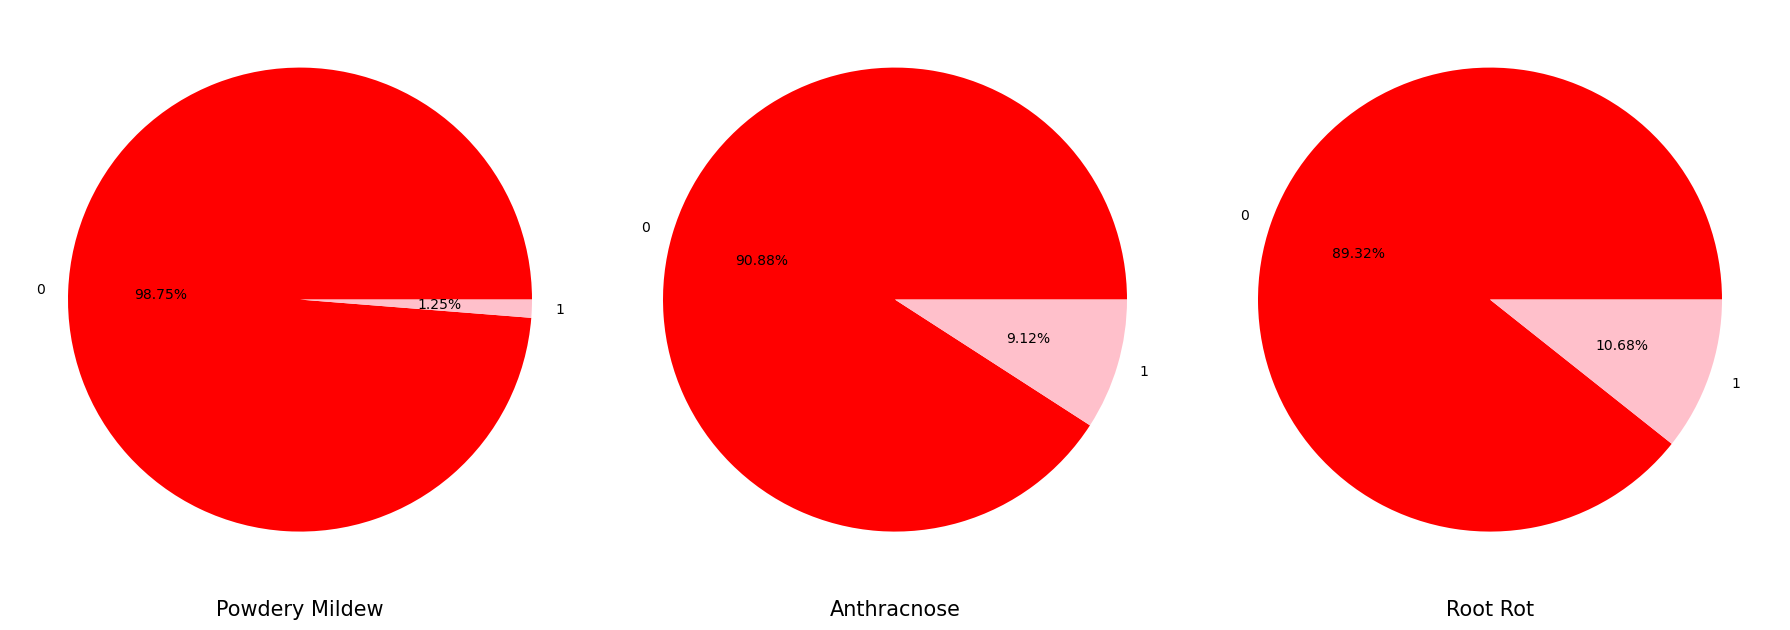

In [83]:
# Figure Size
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 9))

# Categorial data pie chart
data.groupby('Powdery_Mildew').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax1, autopct='%1.2f%%')
data.groupby('Anthracnose').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax2, autopct='%1.2f%%')
data.groupby('Root_Rot').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax3, autopct='%1.2f%%')

# Labels
ax1.set_ylabel('', size=15)
ax2.set_ylabel('', size=15)
ax3.set_ylabel('', size=15)

ax1.set_xlabel('Powdery Mildew', size=15)
ax2.set_xlabel('Anthracnose', size=15)
ax3.set_xlabel('Root Rot', size=15)

# Auto space
plt.tight_layout()

# Display
plt.show()

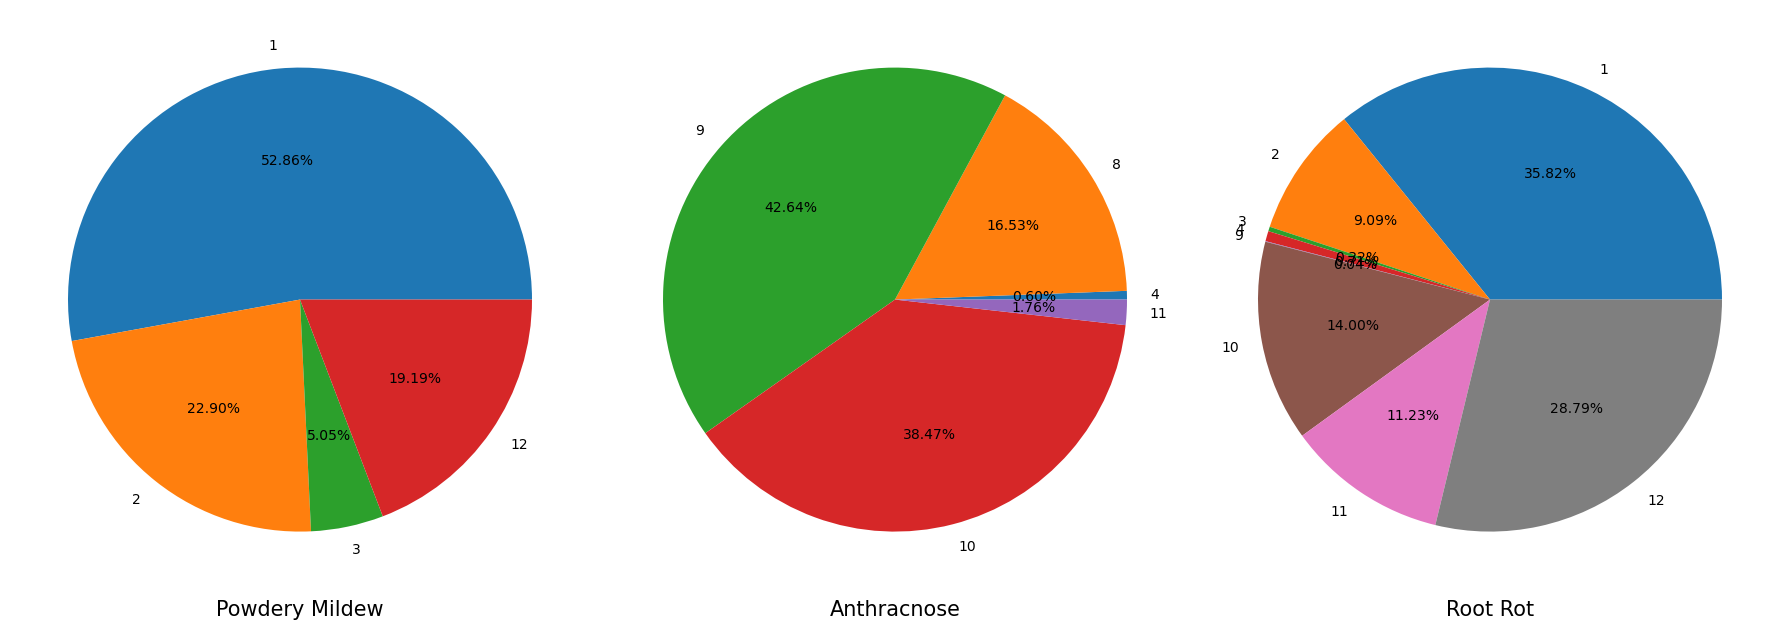

In [84]:
# Figure Size
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 9))

# Categorial data pie chart
p = data.loc[(data['Powdery_Mildew'] == 1)]
p.groupby('Month').size().plot(kind='pie', ax=ax1, autopct='%1.2f%%')
a = data.loc[(data['Anthracnose'] == 1)]
a.groupby('Month').size().plot(kind='pie', ax=ax2, autopct='%1.2f%%')
r = data.loc[(data['Root_Rot'] == 1)]
r.groupby('Month').size().plot(kind='pie', ax=ax3, autopct='%1.2f%%')

# Labels
ax1.set_ylabel('', size=15)
ax2.set_ylabel('', size=15)
ax3.set_ylabel('', size=15)

ax1.set_xlabel('Powdery Mildew', size=15)
ax2.set_xlabel('Anthracnose', size=15)
ax3.set_xlabel('Root Rot', size=15)

# Auto space
plt.tight_layout()

# Display
plt.show()

In [85]:
data.head()

DateTime  Ambient_Temperature  Ambient_Humidity  \
0 2021-08-01 11:14:03             31.92721          70.39309   
1 2021-08-01 11:45:47             30.95120          71.45073   
2 2021-08-01 11:49:13             31.92721          68.08391   
3 2021-08-01 12:24:39             30.83540          72.01481   
4 2021-08-01 13:03:40             31.43093          69.22969   

   Soil_Temperature  Leaf_Wetness_Duration  Soil_Moisture  Powdery_Mildew  \
0          19.61952                    0.0       3.911833               0   
1          19.80149                    0.0       4.187168               0   
2          19.70223                    0.0       4.205964               0   
3          19.76840                    0.0       4.318156               0   
4          19.66915                    0.0       4.134188               0   

   Anthracnose  Root_Rot  Irrigation  Month  Hours  
0            0         0  526.017622      8     11  
1            0         0  502.228721      8     11  
2            0         0  500.604703      8     11  
3            0         0  490.911300      8     12  
4            0         0  506.806183      8     13

In [86]:
# # Figure Size
# fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 9))

# # Categorial data pie chart
# p = data.loc[(data['Powdery_Mildew'] == 1)]
# p.groupby().size().plot(kind='pie', ax=ax1, autopct='%1.2f%%')
# a = data.loc[(data['Anthracnose'] == 1)]
# a.groupby().size().plot(kind='pie', ax=ax2, autopct='%1.2f%%')
# r = data.loc[(data['Root_Rot'] == 1)]
# r.groupby().size().plot(kind='pie', ax=ax3, autopct='%1.2f%%')

# # Labels
# ax1.set_ylabel('', size=15)
# ax2.set_ylabel('', size=15)
# ax3.set_ylabel('', size=15)

# ax1.set_xlabel('Powdery Mildew', size=15)
# ax2.set_xlabel('Anthracnose', size=15)
# ax3.set_xlabel('Root Rot', size=15)

# # Auto space
# plt.tight_layout()

# # Display
# plt.show()

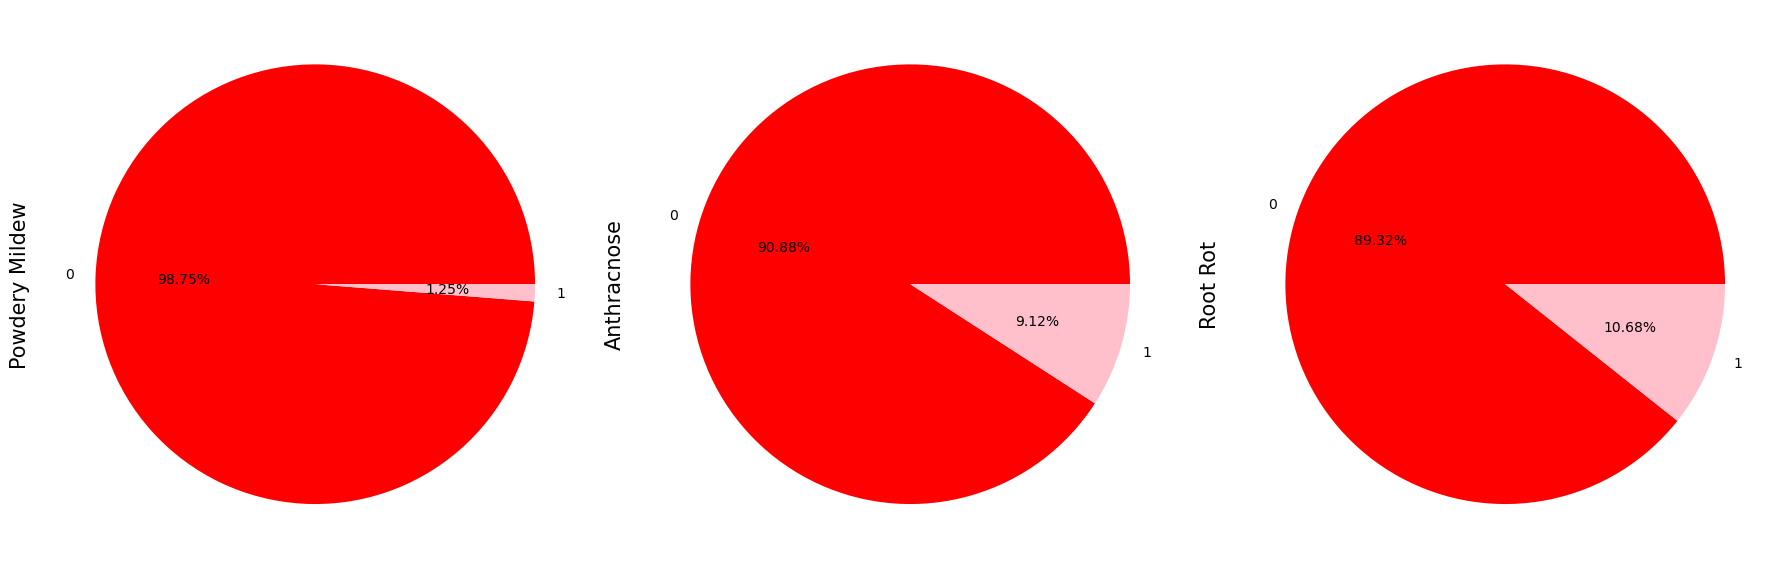

In [87]:
# Figure Size
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 9))

# Categorial data pie chart
data.groupby('Powdery_Mildew').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax1, autopct='%1.2f%%')
data.groupby('Anthracnose').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax2, autopct='%1.2f%%')
data.groupby('Root_Rot').size().plot(kind='pie', colors=
           ['red', 'pink'], ax=ax3, autopct='%1.2f%%')

# Labels
ax1.set_ylabel('Powdery Mildew', size=15)
ax2.set_ylabel('Anthracnose', size=15)
ax3.set_ylabel('Root Rot', size=15)

# Auto space
plt.tight_layout()

# Display
plt.show()

In [88]:
ana=data2.loc[(data2['Month'] == 3) | (data2['Month'] == 4) | (data2['Month'] == 5)]
ana.head(5)

NameError: name 'data2' is not defined

In [89]:
# # ana=data2.loc[(data2['Month'] == 3) | (data2['Month'] == 4) | (data2['Month'] == 5)]
# # ana.head(5)
# ana_irri=ana[['Soil_Moisture','Powdery_Mildew','Anthracnose','Root_Rot','Month','Hours']]
# plt.figure(figsize = (12, 7))
# sns.heatmap(ana_irri.corr(), annot=True, cmap='Blues' )
# plt.show()

#**Neural Network**

In [90]:
data.to_csv('comparision.csv')

In [91]:
# Copy Original Data Into data2
data2 = data

In [92]:
# Drop Records with 0 disease
data2 = data2.drop(np.where((data2['Powdery_Mildew'] == 0) & (data2['Anthracnose'] == 0) & (data2['Root_Rot'] == 0))[0])
print(data2['Powdery_Mildew'].sum(),data2['Anthracnose'].sum(),data2['Root_Rot'].sum())

297 2160 2529


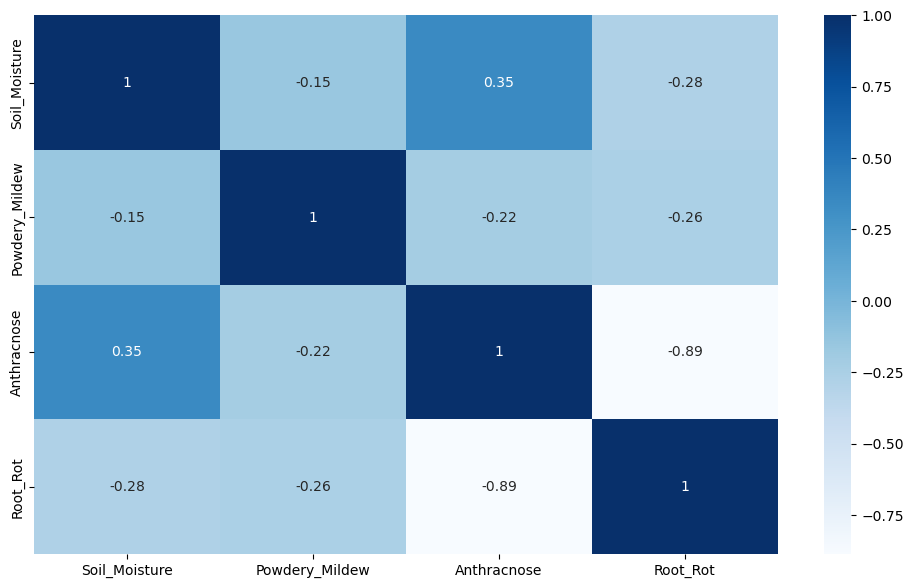

In [93]:
ana_irri=data2[['Soil_Moisture','Powdery_Mildew','Anthracnose','Root_Rot']]
plt.figure(figsize = (12, 7))
sns.heatmap(ana_irri.corr(), annot=True, cmap='Blues' )
plt.show()

**Libraries**

In [94]:
# Import Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import accuracy_score

from keras.models import Sequential, Model
from keras.layers import Dense, Input

2023-07-18 10:14:32.780658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 10:14:34.723632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-18 10:14:34.723693: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-18 10:14:39.430270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Split Data Into X & y**

In [95]:
data2.columns

Index(['DateTime', 'Ambient_Temperature', 'Ambient_Humidity',
       'Soil_Temperature', 'Leaf_Wetness_Duration', 'Soil_Moisture',
       'Powdery_Mildew', 'Anthracnose', 'Root_Rot', 'Irrigation', 'Month',
       'Hours'],
      dtype='object')

In [96]:
# X
X = data2.drop(['DateTime', 'Powdery_Mildew', 'Anthracnose', 'Root_Rot', 'Irrigation'], axis='columns')


# y classification
y_class = data2[['Powdery_Mildew', 'Anthracnose', 'Root_Rot', 'Irrigation']]

**MinMaxScaler**

In [97]:
from sklearn.preprocessing import StandardScaler

# Columns To Scale
cols_to_scale = ['Ambient_Temperature'	,'Ambient_Humidity'	,'Soil_Temperature'	,'Leaf_Wetness_Duration'	,'Soil_Moisture']

# MinMaxScaler
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

ys = y_class['Irrigation'].values.reshape(-1,1)
scaler_irrigation=StandardScaler()
ys=scaler_irrigation.fit_transform(ys)


In [98]:
y_class['Irrigation']=ys

/tmp/ipykernel_17549/1115281250.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Split Train & Test**

In [99]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.20, random_state = 42)

# # Size of Train & Test
print("X Train : ", len(X_train))
print("Y Train : ", len(y_train))
print("X Test : ", len(X_test))
print("Y Test : ", len(y_test))

X Train :  3988
Y Train :  3988
X Test :  998
Y Test :  998


In [100]:
X.head()

Ambient_Temperature  Ambient_Humidity  Soil_Temperature  \
11             0.812537          0.533695          0.791210   
12             0.805970          0.579642          0.789378   
13             0.808955          0.600848          0.756411   
14             0.794030          0.613219          0.754580   
15             0.788060          0.669769          0.754580   

    Leaf_Wetness_Duration  Soil_Moisture  Month  Hours  
11               0.000000       0.556742      8     15  
12               0.000000       0.567640      8     16  
13               0.003718       0.560508      8     16  
14               0.007265       0.549772      8     17  
15               0.010814       0.561971      8     18

**Neural Network Model**

In [101]:
# # NN 
nn = Input(shape=(7,))
hidden1 = Dense(48, activation='relu')(nn)
hidden4 = Dense(24, activation='relu')(hidden1)
# hidden3 = Dense(12, activation='relu')(hidden2)
# hidden4 = Dense(6, activation='relu')(hidden3)

# NN 
# nn = Input(shape=(5,))
# hidden1 = Dense(16, activation='relu')(nn)
# hidden4 = Dense(8, activation='relu')(hidden1)

2023-07-18 10:14:52.095451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-18 10:14:52.095524: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-18 10:14:52.095593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (student-OptiPlex-3040): /proc/driver/nvidia/version does not exist
2023-07-18 10:14:52.103099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [102]:
# Classification Output
out_clas = Dense(3, activation='sigmoid', name='3cls')(hidden4)

In [103]:
# Regression Output
irrigation_out_clas = Dense(1, activation='linear', name='1rg')(hidden4)

In [104]:
# Define Model
# model = Model(inputs=nn, outputs=[out_clas])
model = Model(inputs=nn, outputs=[out_clas,irrigation_out_clas])

In [105]:
# Compile The Model
# model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
 
model.compile(loss={'3cls':'binary_crossentropy', '1rg':'mean_squared_error'}, optimizer='adam',  metrics={'3cls':'accuracy', '1rg':'mse'})
# model.compile(loss={'3cls':'binary_crossentropy', '1rg':'mean_absolute_error'}, optimizer='adam',  metrics={'3cls':'accuracy', '1rg':'mae'})

In [106]:
# Train Model
# history = model.fit(X_train, y_train, validation_split = 0.15, epochs=150, batch_size=24, verbose=1)
# {"out_clas": [y_train.Powdery_Mildew, y_train.Anthracnose, y_train.Root_Rot], "irrigation_out_clas": y_train.Irrigation}

# history = model.fit(X_train
#                     ,y_train
#                     , validation_split = 0.15, epochs=150, batch_size=24, verbose=1)

history_relu = model.fit(X_train
                    ,[ y_train.iloc[:,:3], y_train.iloc[:,3:]]
                    , validation_split = 0.15, epochs=150, batch_size=24, verbose=1)

Epoch 1/150
142/142 [==============================] - 2s 4ms/step - loss: 1.6409 - 3cls_loss: 0.5970 - 1rg_loss: 1.0439 - 3cls_accuracy: 0.6807 - 1rg_mse: 1.0439 - val_loss: 1.3756 - val_3cls_loss: 0.4437 - val_1rg_loss: 0.9319 - val_3cls_accuracy: 0.8531 - val_1rg_mse: 0.9319
Epoch 2/150
142/142 [==============================] - 0s 2ms/step - loss: 1.3616 - 3cls_loss: 0.4406 - 1rg_loss: 0.9210 - 3cls_accuracy: 0.7675 - 1rg_mse: 0.9210 - val_loss: 1.2917 - val_3cls_loss: 0.3981 - val_1rg_loss: 0.8936 - val_3cls_accuracy: 0.8664 - val_1rg_mse: 0.8936
Epoch 3/150
142/142 [==============================] - 0s 2ms/step - loss: 1.2205 - 3cls_loss: 0.3909 - 1rg_loss: 0.8296 - 3cls_accuracy: 0.8011 - 1rg_mse: 0.8296 - val_loss: 1.0942 - val_3cls_loss: 0.3471 - val_1rg_loss: 0.7470 - val_3cls_accuracy: 0.8831 - val_1rg_mse: 0.7470
Epoch 4/150
142/142 [==============================] - 0s 2ms/step - loss: 1.0750 - 3cls_loss: 0.3312 - 1rg_loss: 0.7438 - 3cls_accuracy: 0.8495 - 1rg_mse: 0.7438 

142/142 [==============================] - 0s 3ms/step - loss: 0.4489 - 3cls_loss: 0.0765 - 1rg_loss: 0.3724 - 3cls_accuracy: 0.9543 - 1rg_mse: 0.3724 - val_loss: 0.3699 - val_3cls_loss: 0.0606 - val_1rg_loss: 0.3093 - val_3cls_accuracy: 0.9699 - val_1rg_mse: 0.3093
Epoch 31/150
142/142 [==============================] - 0s 2ms/step - loss: 0.4376 - 3cls_loss: 0.0757 - 1rg_loss: 0.3619 - 3cls_accuracy: 0.9560 - 1rg_mse: 0.3619 - val_loss: 0.3479 - val_3cls_loss: 0.0586 - val_1rg_loss: 0.2893 - val_3cls_accuracy: 0.9666 - val_1rg_mse: 0.2893
Epoch 32/150
142/142 [==============================] - 0s 2ms/step - loss: 0.4317 - 3cls_loss: 0.0737 - 1rg_loss: 0.3580 - 3cls_accuracy: 0.9578 - 1rg_mse: 0.3580 - val_loss: 0.3646 - val_3cls_loss: 0.0624 - val_1rg_loss: 0.3022 - val_3cls_accuracy: 0.9649 - val_1rg_mse: 0.3022
Epoch 33/150
142/142 [==============================] - 0s 2ms/step - loss: 0.4191 - 3cls_loss: 0.0710 - 1rg_loss: 0.3480 - 3cls_accuracy: 0.9616 - 1rg_mse: 0.3480 - val_los

142/142 [==============================] - 0s 2ms/step - loss: 0.3063 - 3cls_loss: 0.0434 - 1rg_loss: 0.2630 - 3cls_accuracy: 0.9752 - 1rg_mse: 0.2630 - val_loss: 0.2575 - val_3cls_loss: 0.0307 - val_1rg_loss: 0.2268 - val_3cls_accuracy: 0.9800 - val_1rg_mse: 0.2268
Epoch 60/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2966 - 3cls_loss: 0.0429 - 1rg_loss: 0.2537 - 3cls_accuracy: 0.9785 - 1rg_mse: 0.2537 - val_loss: 0.2596 - val_3cls_loss: 0.0330 - val_1rg_loss: 0.2266 - val_3cls_accuracy: 0.9783 - val_1rg_mse: 0.2266
Epoch 61/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2916 - 3cls_loss: 0.0424 - 1rg_loss: 0.2492 - 3cls_accuracy: 0.9785 - 1rg_mse: 0.2492 - val_loss: 0.2588 - val_3cls_loss: 0.0322 - val_1rg_loss: 0.2267 - val_3cls_accuracy: 0.9766 - val_1rg_mse: 0.2267
Epoch 62/150
142/142 [==============================] - 0s 2ms/step - loss: 0.3194 - 3cls_loss: 0.0421 - 1rg_loss: 0.2773 - 3cls_accuracy: 0.9790 - 1rg_mse: 0.2773 - val_los

142/142 [==============================] - 0s 2ms/step - loss: 0.2632 - 3cls_loss: 0.0370 - 1rg_loss: 0.2262 - 3cls_accuracy: 0.9770 - 1rg_mse: 0.2262 - val_loss: 0.2795 - val_3cls_loss: 0.0266 - val_1rg_loss: 0.2529 - val_3cls_accuracy: 0.9783 - val_1rg_mse: 0.2529
Epoch 89/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2638 - 3cls_loss: 0.0368 - 1rg_loss: 0.2270 - 3cls_accuracy: 0.9776 - 1rg_mse: 0.2270 - val_loss: 0.2351 - val_3cls_loss: 0.0254 - val_1rg_loss: 0.2097 - val_3cls_accuracy: 0.9800 - val_1rg_mse: 0.2097
Epoch 90/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2806 - 3cls_loss: 0.0356 - 1rg_loss: 0.2451 - 3cls_accuracy: 0.9802 - 1rg_mse: 0.2451 - val_loss: 0.2290 - val_3cls_loss: 0.0254 - val_1rg_loss: 0.2036 - val_3cls_accuracy: 0.9800 - val_1rg_mse: 0.2036
Epoch 91/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2647 - 3cls_loss: 0.0360 - 1rg_loss: 0.2287 - 3cls_accuracy: 0.9779 - 1rg_mse: 0.2287 - val_los

142/142 [==============================] - 0s 2ms/step - loss: 0.2477 - 3cls_loss: 0.0326 - 1rg_loss: 0.2151 - 3cls_accuracy: 0.9808 - 1rg_mse: 0.2151 - val_loss: 0.2429 - val_3cls_loss: 0.0218 - val_1rg_loss: 0.2211 - val_3cls_accuracy: 0.9883 - val_1rg_mse: 0.2211
Epoch 118/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2415 - 3cls_loss: 0.0362 - 1rg_loss: 0.2053 - 3cls_accuracy: 0.9805 - 1rg_mse: 0.2053 - val_loss: 0.2076 - val_3cls_loss: 0.0290 - val_1rg_loss: 0.1785 - val_3cls_accuracy: 0.9816 - val_1rg_mse: 0.1785
Epoch 119/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2446 - 3cls_loss: 0.0332 - 1rg_loss: 0.2115 - 3cls_accuracy: 0.9802 - 1rg_mse: 0.2115 - val_loss: 0.2152 - val_3cls_loss: 0.0258 - val_1rg_loss: 0.1893 - val_3cls_accuracy: 0.9833 - val_1rg_mse: 0.1893
Epoch 120/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2387 - 3cls_loss: 0.0340 - 1rg_loss: 0.2047 - 3cls_accuracy: 0.9790 - 1rg_mse: 0.2047 - val_

142/142 [==============================] - 0s 2ms/step - loss: 0.2276 - 3cls_loss: 0.0285 - 1rg_loss: 0.1991 - 3cls_accuracy: 0.9832 - 1rg_mse: 0.1991 - val_loss: 0.1910 - val_3cls_loss: 0.0180 - val_1rg_loss: 0.1730 - val_3cls_accuracy: 0.9900 - val_1rg_mse: 0.1730
Epoch 147/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2268 - 3cls_loss: 0.0288 - 1rg_loss: 0.1980 - 3cls_accuracy: 0.9835 - 1rg_mse: 0.1980 - val_loss: 0.1856 - val_3cls_loss: 0.0222 - val_1rg_loss: 0.1634 - val_3cls_accuracy: 0.9800 - val_1rg_mse: 0.1634
Epoch 148/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2197 - 3cls_loss: 0.0314 - 1rg_loss: 0.1884 - 3cls_accuracy: 0.9799 - 1rg_mse: 0.1884 - val_loss: 0.2084 - val_3cls_loss: 0.0437 - val_1rg_loss: 0.1646 - val_3cls_accuracy: 0.9716 - val_1rg_mse: 0.1646
Epoch 149/150
142/142 [==============================] - 0s 2ms/step - loss: 0.2311 - 3cls_loss: 0.0298 - 1rg_loss: 0.2013 - 3cls_accuracy: 0.9811 - 1rg_mse: 0.2013 - val_

In [210]:
# Train Model
# history = model.fit(X_train, y_train, validation_split = 0.15, epochs=150, batch_size=24, verbose=1)
# {"out_clas": [y_train.Powdery_Mildew, y_train.Anthracnose, y_train.Root_Rot], "irrigation_out_clas": y_train.Irrigation}

# history = model.fit(X_train
#                     ,y_train
#                     , validation_split = 0.15, epochs=150, batch_size=24, verbose=1)

history_linear = model.fit(X_train, [y_train.iloc[:,:3], y_train.iloc[:,3:]], validation_split=0.15, epochs=150, batch_size=32, verbose=1)


Epoch 1/150
159/159 [==============================] - 1s 3ms/step - loss: 1.4881 - 3cls_loss: 0.5570 - 1rg_loss: 0.9311 - 3cls_accuracy: 0.5345 - 1rg_mse: 0.9311 - val_loss: 1.2567 - val_3cls_loss: 0.4858 - val_1rg_loss: 0.7709 - val_3cls_accuracy: 0.5530 - val_1rg_mse: 0.7709
Epoch 2/150
159/159 [==============================] - 0s 3ms/step - loss: 1.1737 - 3cls_loss: 0.4678 - 1rg_loss: 0.7058 - 3cls_accuracy: 0.5591 - 1rg_mse: 0.7058 - val_loss: 1.1318 - val_3cls_loss: 0.4548 - val_1rg_loss: 0.6771 - val_3cls_accuracy: 0.5897 - val_1rg_mse: 0.6771
Epoch 3/150
159/159 [==============================] - 0s 2ms/step - loss: 1.0609 - 3cls_loss: 0.4448 - 1rg_loss: 0.6161 - 3cls_accuracy: 0.6209 - 1rg_mse: 0.6161 - val_loss: 1.0116 - val_3cls_loss: 0.4422 - val_1rg_loss: 0.5695 - val_3cls_accuracy: 0.6176 - val_1rg_mse: 0.5695
Epoch 4/150
159/159 [==============================] - 0s 2ms/step - loss: 0.9504 - 3cls_loss: 0.4313 - 1rg_loss: 0.5191 - 3cls_accuracy: 0.6532 - 1rg_mse: 0.5191 

159/159 [==============================] - 0s 3ms/step - loss: 0.1822 - 3cls_loss: 0.1341 - 1rg_loss: 0.0481 - 3cls_accuracy: 0.9263 - 1rg_mse: 0.0481 - val_loss: 0.1916 - val_3cls_loss: 0.1452 - val_1rg_loss: 0.0463 - val_3cls_accuracy: 0.9242 - val_1rg_mse: 0.0463
Epoch 60/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1879 - 3cls_loss: 0.1345 - 1rg_loss: 0.0534 - 3cls_accuracy: 0.9263 - 1rg_mse: 0.0534 - val_loss: 0.1847 - val_3cls_loss: 0.1426 - val_1rg_loss: 0.0422 - val_3cls_accuracy: 0.9220 - val_1rg_mse: 0.0422
Epoch 61/150
159/159 [==============================] - 0s 3ms/step - loss: 0.1791 - 3cls_loss: 0.1325 - 1rg_loss: 0.0466 - 3cls_accuracy: 0.9244 - 1rg_mse: 0.0466 - val_loss: 0.1825 - val_3cls_loss: 0.1447 - val_1rg_loss: 0.0378 - val_3cls_accuracy: 0.9242 - val_1rg_mse: 0.0378
Epoch 62/150
159/159 [==============================] - 1s 3ms/step - loss: 0.1819 - 3cls_loss: 0.1327 - 1rg_loss: 0.0492 - 3cls_accuracy: 0.9242 - 1rg_mse: 0.0492 - val_los

159/159 [==============================] - 0s 3ms/step - loss: 0.1293 - 3cls_loss: 0.0958 - 1rg_loss: 0.0335 - 3cls_accuracy: 0.9348 - 1rg_mse: 0.0335 - val_loss: 0.1225 - val_3cls_loss: 0.0998 - val_1rg_loss: 0.0227 - val_3cls_accuracy: 0.9420 - val_1rg_mse: 0.0227
Epoch 118/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1292 - 3cls_loss: 0.0963 - 1rg_loss: 0.0329 - 3cls_accuracy: 0.9342 - 1rg_mse: 0.0329 - val_loss: 0.1410 - val_3cls_loss: 0.0957 - val_1rg_loss: 0.0452 - val_3cls_accuracy: 0.9342 - val_1rg_mse: 0.0452
Epoch 119/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1247 - 3cls_loss: 0.0929 - 1rg_loss: 0.0318 - 3cls_accuracy: 0.9374 - 1rg_mse: 0.0318 - val_loss: 0.1306 - val_3cls_loss: 0.0997 - val_1rg_loss: 0.0309 - val_3cls_accuracy: 0.9376 - val_1rg_mse: 0.0309
Epoch 120/150
159/159 [==============================] - 0s 3ms/step - loss: 0.1244 - 3cls_loss: 0.0914 - 1rg_loss: 0.0330 - 3cls_accuracy: 0.9411 - 1rg_mse: 0.0330 - val_

In [211]:
# Train Model
# history = model.fit(X_train, y_train, validation_split = 0.15, epochs=150, batch_size=24, verbose=1)
# {"out_clas": [y_train.Powdery_Mildew, y_train.Anthracnose, y_train.Root_Rot], "irrigation_out_clas": y_train.Irrigation}

# history = model.fit(X_train
#                     ,y_train
#                     , validation_split = 0.15, epochs=150, batch_size=24, verbose=1)

history = model.fit(X_train
                    ,[ y_train.iloc[:,:3], y_train.iloc[:,3:]]
                    , validation_split = 0.15, epochs=150, batch_size=24, verbose=1)

Epoch 1/150
212/212 [==============================] - 0s 2ms/step - loss: 0.1110 - 3cls_loss: 0.0801 - 1rg_loss: 0.0308 - 3cls_accuracy: 0.9401 - 1rg_mse: 0.0308 - val_loss: 0.1101 - val_3cls_loss: 0.0844 - val_1rg_loss: 0.0257 - val_3cls_accuracy: 0.9320 - val_1rg_mse: 0.0257
Epoch 2/150
212/212 [==============================] - 0s 2ms/step - loss: 0.1118 - 3cls_loss: 0.0806 - 1rg_loss: 0.0311 - 3cls_accuracy: 0.9382 - 1rg_mse: 0.0311 - val_loss: 0.1101 - val_3cls_loss: 0.0852 - val_1rg_loss: 0.0249 - val_3cls_accuracy: 0.9398 - val_1rg_mse: 0.0249
Epoch 3/150
212/212 [==============================] - 0s 2ms/step - loss: 0.1068 - 3cls_loss: 0.0789 - 1rg_loss: 0.0279 - 3cls_accuracy: 0.9395 - 1rg_mse: 0.0279 - val_loss: 0.1089 - val_3cls_loss: 0.0811 - val_1rg_loss: 0.0278 - val_3cls_accuracy: 0.9409 - val_1rg_mse: 0.0278
Epoch 4/150
212/212 [==============================] - 0s 2ms/step - loss: 0.1060 - 3cls_loss: 0.0783 - 1rg_loss: 0.0277 - 3cls_accuracy: 0.9405 - 1rg_mse: 0.0277 

212/212 [==============================] - 0s 2ms/step - loss: 0.0753 - 3cls_loss: 0.0535 - 1rg_loss: 0.0218 - 3cls_accuracy: 0.9565 - 1rg_mse: 0.0218 - val_loss: 0.0751 - val_3cls_loss: 0.0591 - val_1rg_loss: 0.0160 - val_3cls_accuracy: 0.9498 - val_1rg_mse: 0.0160
Epoch 60/150
212/212 [==============================] - 0s 2ms/step - loss: 0.0779 - 3cls_loss: 0.0543 - 1rg_loss: 0.0236 - 3cls_accuracy: 0.9569 - 1rg_mse: 0.0236 - val_loss: 0.0770 - val_3cls_loss: 0.0588 - val_1rg_loss: 0.0181 - val_3cls_accuracy: 0.9554 - val_1rg_mse: 0.0181
Epoch 61/150
212/212 [==============================] - 0s 2ms/step - loss: 0.0762 - 3cls_loss: 0.0543 - 1rg_loss: 0.0219 - 3cls_accuracy: 0.9575 - 1rg_mse: 0.0219 - val_loss: 0.0743 - val_3cls_loss: 0.0612 - val_1rg_loss: 0.0131 - val_3cls_accuracy: 0.9476 - val_1rg_mse: 0.0131
Epoch 62/150
212/212 [==============================] - 0s 2ms/step - loss: 0.0770 - 3cls_loss: 0.0568 - 1rg_loss: 0.0203 - 3cls_accuracy: 0.9567 - 1rg_mse: 0.0203 - val_los

212/212 [==============================] - 0s 2ms/step - loss: 0.0547 - 3cls_loss: 0.0385 - 1rg_loss: 0.0162 - 3cls_accuracy: 0.9651 - 1rg_mse: 0.0162 - val_loss: 0.0701 - val_3cls_loss: 0.0563 - val_1rg_loss: 0.0139 - val_3cls_accuracy: 0.9543 - val_1rg_mse: 0.0139
Epoch 118/150
212/212 [==============================] - 0s 2ms/step - loss: 0.0518 - 3cls_loss: 0.0371 - 1rg_loss: 0.0146 - 3cls_accuracy: 0.9685 - 1rg_mse: 0.0146 - val_loss: 0.0605 - val_3cls_loss: 0.0538 - val_1rg_loss: 0.0066 - val_3cls_accuracy: 0.9543 - val_1rg_mse: 0.0066
Epoch 119/150
212/212 [==============================] - 1s 3ms/step - loss: 0.0601 - 3cls_loss: 0.0408 - 1rg_loss: 0.0192 - 3cls_accuracy: 0.9689 - 1rg_mse: 0.0192 - val_loss: 0.0679 - val_3cls_loss: 0.0588 - val_1rg_loss: 0.0091 - val_3cls_accuracy: 0.9443 - val_1rg_mse: 0.0091
Epoch 120/150
212/212 [==============================] - 0s 2ms/step - loss: 0.0598 - 3cls_loss: 0.0413 - 1rg_loss: 0.0185 - 3cls_accuracy: 0.9636 - 1rg_mse: 0.0185 - val_

**Plot Model**

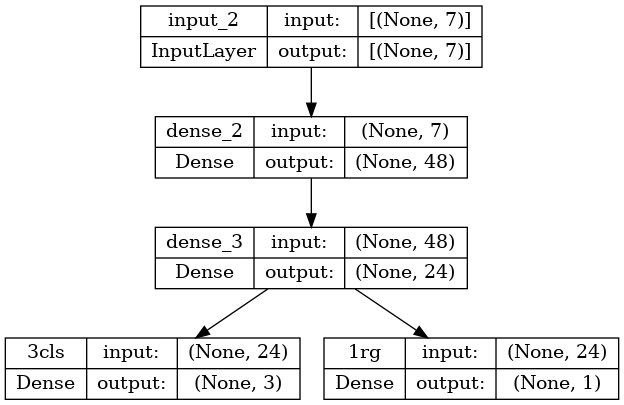

In [212]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [213]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 48)           384         ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 24)           1176        ['dense_2[0][0]']                
                                                                                                  
 3cls (Dense)                   (None, 3)            75          ['dense_3[0][0]']                
                                                                                            

**Plot Loss & Accuracy**

In [214]:
plt.rc('font',size=12)

0.04916766285896301


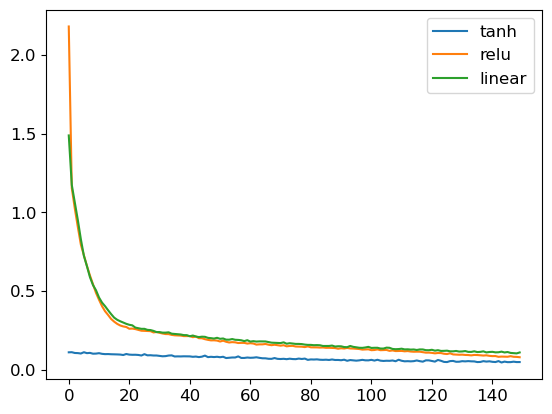

In [215]:
# Loss
print(history.history['loss'][-1])
plt.plot(history.history['loss'])
plt.plot(history_relu.history['loss'])
plt.plot(history_linear.history['loss'])
plt.legend(['tanh','relu','linear'], loc='best')


In [216]:
plt.rc('font', size=12, weight='bold')     # tick labels bigger

0.11007073521614075


(0.0, 1.0)

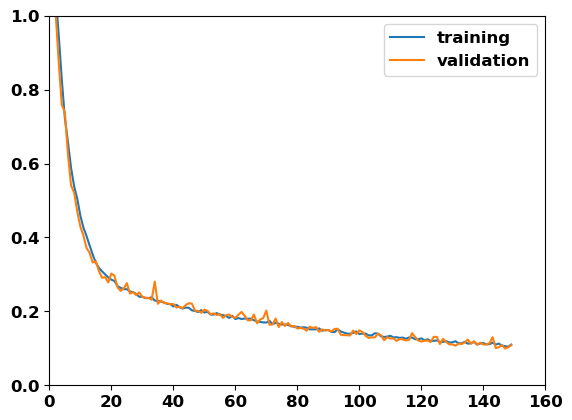

In [217]:
# Accuracy
print(history_linear.history['loss'][-1])
plt.plot(history_linear.history['loss'])
plt.plot(history_linear.history['val_loss'])
plt.legend(['training','validation'], loc='best')
plt.xlim(0,160,10)
plt.ylim(0,1)


0.9377707839012146


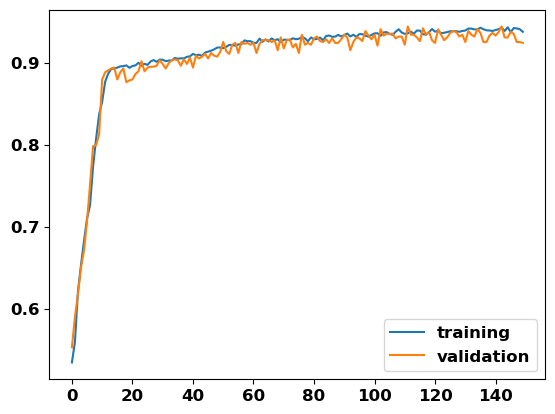

In [218]:
# Accuracy
print(history_linear.history['3cls_accuracy'][-1])
plt.plot(history_linear.history['3cls_accuracy'])
plt.plot(history_linear.history['val_3cls_accuracy'])
plt.legend(['training','validation'], loc='best')

# plt.xlim(0,150,10)
# plt.ylim(0,1)

0.028864093124866486


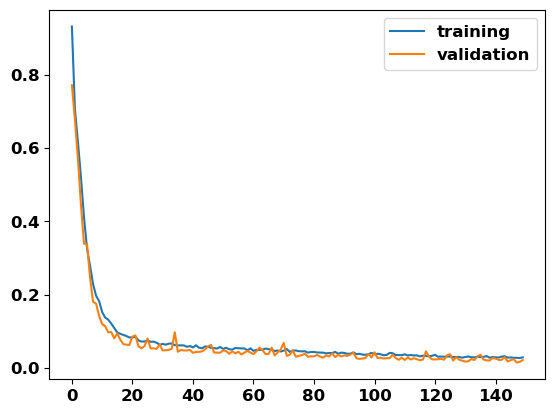

In [219]:
# Accuracy
print(history_linear.history['1rg_mse'][-1])
plt.plot(history_linear.history['1rg_mse'])
plt.plot(history_linear.history['val_1rg_mse'])
plt.legend(['training','validation'], loc='best')


0.028864093124866486


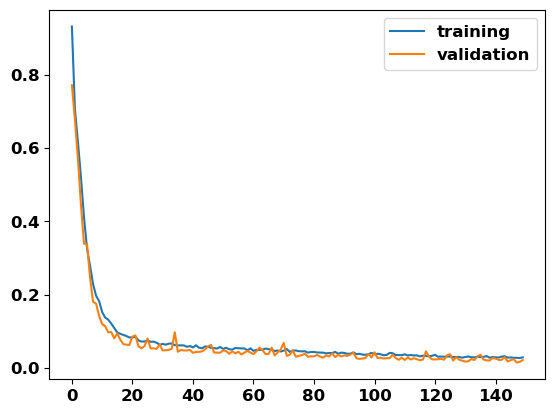

In [220]:
# # Accuracy
# print(history.history['1rg_mse'][-1])
# plt.plot(history.history['1rg_mse'])
# plt.plot(history.history['val_1rg_mse'])

# Accuracy
print(history_linear.history['1rg_mse'][-1])
plt.plot(history_linear.history['1rg_mse'])
plt.plot(history_linear.history['val_1rg_mse'])
plt.legend(['training','validation'], loc='best')


In [221]:
history_linear.history.keys()

dict_keys(['loss', '3cls_loss', '1rg_loss', '3cls_accuracy', '1rg_mse', 'val_loss', 'val_3cls_loss', 'val_1rg_loss', 'val_3cls_accuracy', 'val_1rg_mse'])

0.08120663464069366


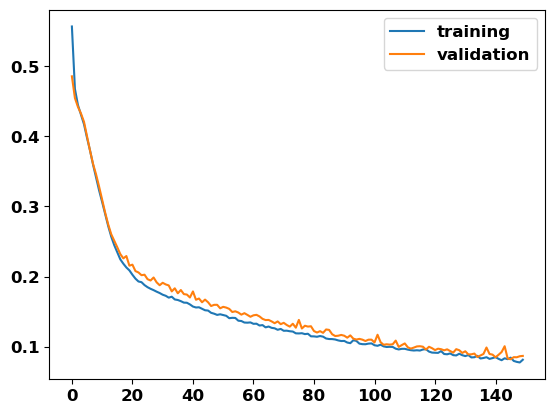

In [222]:
# # Accuracy
# print(history.history['1rg_mse'][-1])
# plt.plot(history.history['1rg_mse'])
# plt.plot(history.history['val_1rg_mse'])

# Accuracy
print(history_linear.history['3cls_loss'][-1])
plt.plot(history_linear.history['3cls_loss'])
plt.plot(history_linear.history['val_3cls_loss'])
plt.legend(['training','validation'], loc='best')


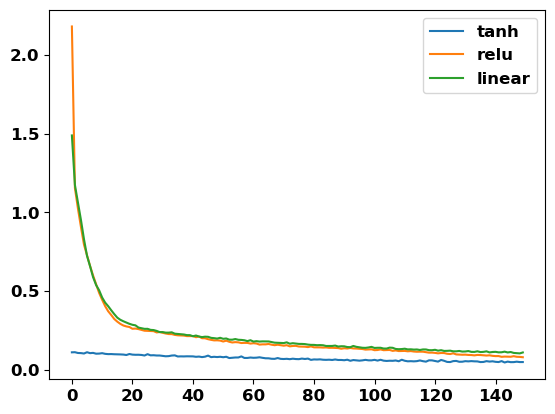

In [223]:
plt.plot(history.history['loss'])
plt.plot(history_relu.history['loss'])
plt.plot(history_linear.history['loss'])
plt.legend(['tanh','relu','linear'], loc='best')

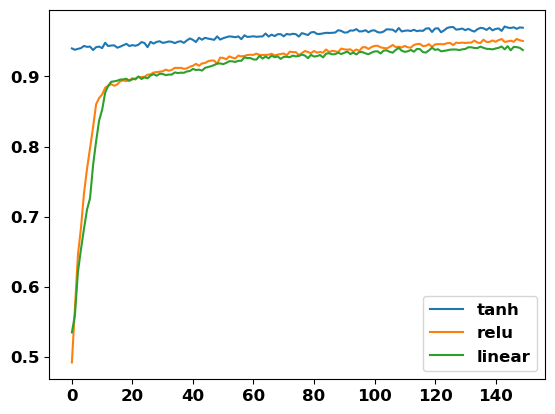

In [224]:
plt.plot(history.history['3cls_accuracy'])
plt.plot(history_relu.history['3cls_accuracy'])
plt.plot(history_linear.history['3cls_accuracy'])
plt.legend(['tanh','relu','linear'], loc='best')

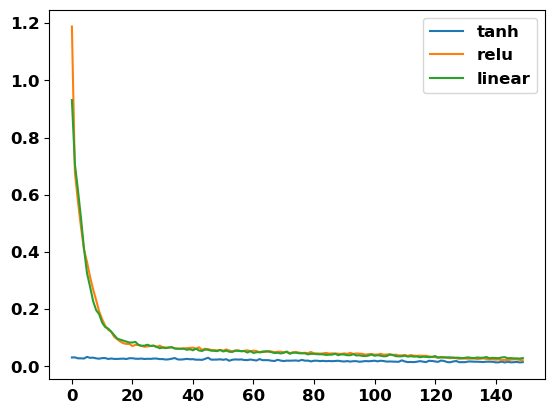

In [225]:
plt.plot(history.history['1rg_mse'])
plt.plot(history_relu.history['1rg_mse'])

plt.plot(history_linear.history['1rg_mse'])
plt.legend(['tanh','relu','linear'], loc='best')

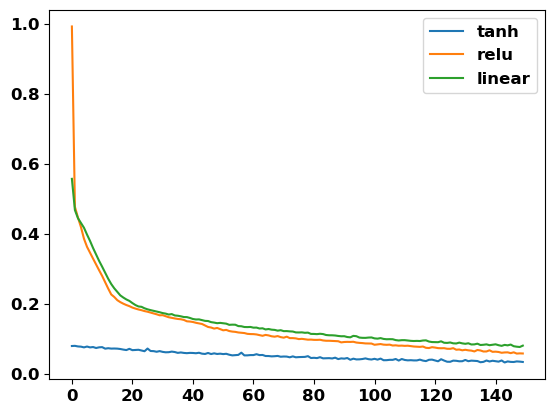

In [226]:
plt.plot(history.history['3cls_loss'])
plt.plot(history_relu.history['3cls_loss'])
plt.plot(history_linear.history['3cls_loss'])
plt.legend(['tanh','relu','linear'], loc='best')

<AxesSubplot:>

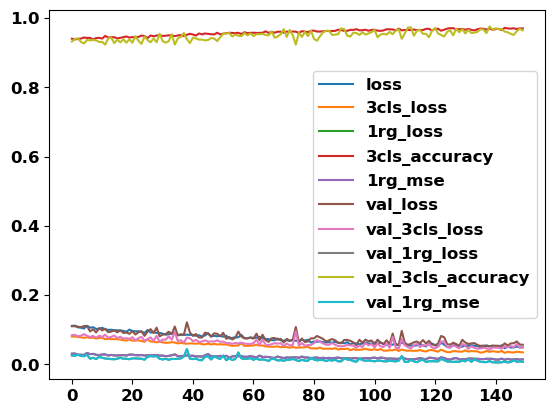

In [227]:
# Plot Evaluation
pd.DataFrame(model.history.history).plot()

**Prediction**

In [228]:
# Make Predictions on Test Data
yhat = model.predict(X_test)

# Display Prediction
# yhat

47/47 [==============================] - 0s 1ms/step


In [229]:
# Powdery Mildew Prediction
p_yhat = yhat[0][:,0]
# Create DataFrame of Powdery Mildew Predicted 
p = pd.DataFrame(p_yhat, columns = ['Powdery_Mildew'])

# Anthracnose Prediction
a_yhat = yhat[0][:,1]
# Create DataFrame of Powdery Mildew Predicted 
a = pd.DataFrame(a_yhat, columns = ['Anthracnose'])

# Root Rot Prediction
r_yhat = yhat[0][:,2]
# Create DataFrame of Root Rot Predicted 
r = pd.DataFrame(r_yhat, columns = ['Root_Rot'])

# Use Threasold To Convert The Value 0 & 1
p_predicted = []
for i in range(len(p)):
  if(p['Powdery_Mildew'][i] >= 0.5):
    p_predicted.append(1)
  else:
    p_predicted.append(0)

# Use Threasold To Convert The Value 0 & 1
a_predicted = []
for i in range(len(a)):
  if(a['Anthracnose'][i] >= 0.5):
    a_predicted.append(1)
  else:
    a_predicted.append(0)

# Use Threasold To Convert The Value 0 & 1
r_predicted = []
for i in range(len(r)):
  if(r['Root_Rot'][i] >= 0.5):
    r_predicted.append(1)
  else:
    r_predicted.append(0)

In [230]:
yhat_df = pd.DataFrame(yhat[1], columns = ['Irrigation'])
new=scaler_irrigation.inverse_transform(yhat_df)
new_df = pd.DataFrame(new, columns = ['Irrigation'])
new_df.to_csv('y_pred.csv')

#**For validation**

In [231]:
find_points = model.predict(X)
find_points_df = pd.DataFrame(find_points[1], columns = ['Irrigation'])
new=scaler_irrigation.inverse_transform(find_points_df)
new_df = pd.DataFrame(new, columns = ['Irrigation'])

test = pd.DataFrame(y_class['Irrigation'], columns = ['Irrigation'])
test=scaler_irrigation.inverse_transform(test)
test = pd.DataFrame(test, columns = ['Irrigation'])

data2.to_csv('comparision.csv')
test.to_csv('y_class_test.csv')
new_df.to_csv('y_class_pred.csv')


234/234 [==============================] - 0s 1ms/step


**Accuracy**

In [232]:
p_acc = accuracy_score(y_test['Powdery_Mildew'], p_predicted)
print('Powdery Mildew Accuracy : %.3f' % p_acc)

a_acc = accuracy_score(y_test['Anthracnose'], a_predicted)
print('Anthracnose Accuracy : %.3f' % a_acc)

r_acc = accuracy_score(y_test['Root_Rot'], r_predicted)
print('Root Rot Accuracy : %.3f' % r_acc)

Powdery Mildew Accuracy : 0.995
Anthracnose Accuracy : 0.983
Root Rot Accuracy : 0.977


In [233]:
len(y_test['Irrigation'])

1494

In [234]:
test = pd.DataFrame(y_test['Irrigation'], columns = ['Irrigation'])
test=scaler_irrigation.inverse_transform(test)
test = pd.DataFrame(test, columns = ['Irrigation'])
test.to_csv('y_test.csv')


In [235]:
y_predicted = pd.DataFrame(list(zip(p_predicted, a_predicted, r_predicted)), columns=['P','A','R'])
# y_predicted.head()

In [236]:
from sklearn.metrics import classification_report
print(classification_report(y_test.iloc[:,:3], y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        64
           1       0.97      0.99      0.98       593
           2       0.98      0.98      0.98       874

   micro avg       0.98      0.98      0.98      1531
   macro avg       0.97      0.96      0.97      1531
weighted avg       0.98      0.98      0.98      1531
 samples avg       0.98      0.98      0.98      1531



/home/student/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [237]:
y_predicted = pd.DataFrame(list(zip(p_predicted, a_predicted, r_predicted)), columns=['P','A','R'])
# y_predicted.head()

[[1427    3]
 [   5   59]]


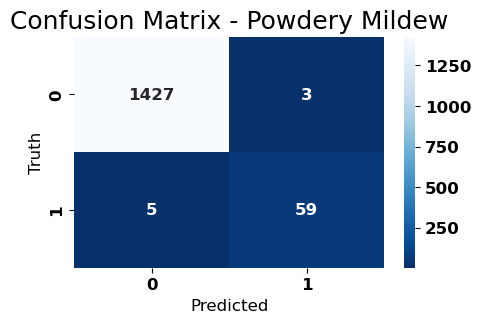

In [238]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix
cm_powdery = confusion_matrix(y_test.iloc[:,0], y_predicted.iloc[:,0])
print(cm_powdery)

# Confusion Matrix Using Seaborn
plt.figure(figsize=(5,3))
sns.heatmap(cm_powdery, annot=True, fmt='.0f', cmap="Blues_r")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title('Confusion Matrix - Powdery Mildew',fontsize=18)
plt.show()

[[882  19]
 [  6 587]]


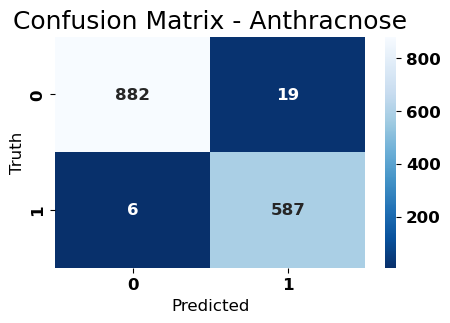

In [239]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix
cm_anthracnose = confusion_matrix(y_test.iloc[:,1], y_predicted.iloc[:,1])
print(cm_anthracnose)

# Confusion Matrix Using Seaborn
plt.figure(figsize=(5,3))
sns.heatmap(cm_anthracnose, annot=True, fmt='.0f', cmap="Blues_r")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title('Confusion Matrix - Anthracnose',fontsize=18)
plt.show()

[[604  16]
 [ 18 856]]


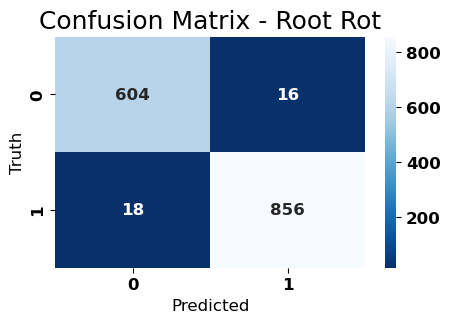

In [240]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix
cm_root = confusion_matrix(y_test.iloc[:,2], y_predicted.iloc[:,2])
print(cm_root)

# Confusion Matrix Using Seaborn
plt.figure(figsize=(5,3))
sns.heatmap(cm_root, annot=True, fmt='.0f', cmap="Blues_r")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title('Confusion Matrix - Root Rot',fontsize=18)
plt.show()

**Calculate AUC - ROC Score**

In [241]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate AUC - ROC
powdery_disease = roc_auc_score(y_test.iloc[:,0], y_predicted.iloc[:,0])
anthracnose_disease = roc_auc_score(y_test.iloc[:,1], y_predicted.iloc[:,1])
root_disease = roc_auc_score(y_test.iloc[:,2], y_predicted.iloc[:,2])

# Display AUC-ROC Score
#print("\nRandom Predictions (AUC - ROC) : %.3f" % (random_auc))
print("\nPowdery Mildew Disease (AUC - ROC) : %.3f" % (powdery_disease))
print("\nAnthracnose Disease (AUC - ROC) : %.3f" % (anthracnose_disease))
print("\nRoot Rot Disease (AUC - ROC) : %.3f" % (root_disease))


Powdery Mildew Disease (AUC - ROC) : 0.960

Anthracnose Disease (AUC - ROC) : 0.984

Root Rot Disease (AUC - ROC) : 0.977


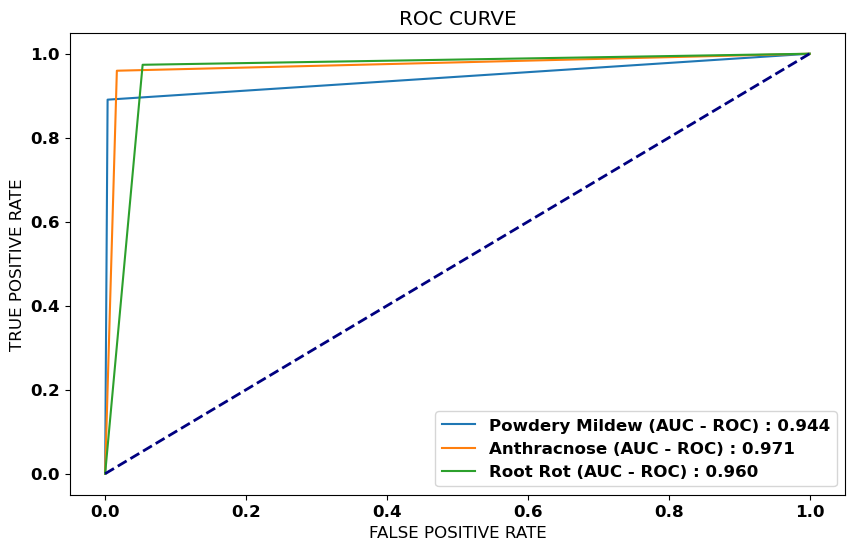

In [182]:
# FPR & TPR
powdery_fpr, powdery_tpr, _ = roc_curve(y_test.iloc[:,0], y_predicted.iloc[:,0])
anthracnose_fpr, anthracnose_tpr, _ = roc_curve(y_test.iloc[:,1], y_predicted.iloc[:,1])
root_fpr, root_tpr, _ = roc_curve(y_test.iloc[:,2], y_predicted.iloc[:,2])

# ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(powdery_fpr, powdery_tpr, linestyle='-', label='Powdery Mildew (AUC - ROC) : %.3f' % (powdery_disease))
plt.plot(anthracnose_fpr, anthracnose_tpr, linestyle='-', label='Anthracnose (AUC - ROC) : %.3f' % (anthracnose_disease))
plt.plot(root_fpr, root_tpr, linestyle='-', label='Root Rot (AUC - ROC) : %.3f' % (root_disease))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')

# Title
plt.title('ROC CURVE')

# Axis Labels
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")

# Show Legend
plt.legend(loc='best')

# Show Plot
plt.show()

#**Save and Load model Codes**

In [183]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("D:\DAIICT\SEM_2\JRF\Irrigation\weights.h5")
# print("model saved to disk")
 
# later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [184]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(history, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_1
.........vars
............0
............1
......mean_2
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5            

In [185]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_1
.........vars
............0
............1
......mean_2
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5            